In [1]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from datasets import load_dataset, load_dataset_builder
from transformers import AutoTokenizer, AutoModel
import gc

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
import matplotlib

import pickle
import time
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

In [2]:
torch.__version__

'2.1.1+cu121'

In [3]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.data_stuff import (
    MultOverlappingSentencesPairDataset,
    SameSentencePairDataset
)
from text_embeddings_src.metrics import knn_accuracy

In [4]:
import jupyter_black

jupyter_black.load(line_length=79)

In [5]:
variables_path = Path("../../results/variables")
figures_path = Path("../../results/figures/updated_dataset")
data_path = Path("../../data")

In [6]:
# MANUAL FIX TO PATH ISSUE FROM VSCODE
import text_embeddings_src

nb_path = Path(text_embeddings_src.__path__[0]).parents[0] / Path(
    "scripts/updated_dataset"
)
assert nb_path.exists(), "The path does not exist"

variables_path = (nb_path / variables_path).resolve(strict=True)
figures_path = (nb_path / figures_path).resolve(strict=True)
data_path = (nb_path / data_path).resolve(strict=True)

In [7]:
figures_path

PosixPath('/gpfs01/berens/user/rgonzalesmarquez/phd/text-embeddings/results/figures/updated_dataset')

In [8]:
plt.style.use((nb_path / Path("../matplotlib_style.txt")).resolve(strict=True))

In [9]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers -p openTSNE
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2024-09-16 22:03:29CEST

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.18.1

openTSNE: 1.0.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 3.10.0-1160.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

jupyter_black      : 0.3.4
scipy              : 1.11.4
memory_profiler    : 0.61.0
numpy              : 1.26.2
matplotlib         : 3.8.2
distro             : 1.8.0
torch              : 2.1.1
pandas             : 2.1.3
text_embeddings_src: 0.0.0

Watermark: 2.4.3

Ubuntu 22.04.3 LTS


# Functions

In [10]:
def fix_all_seeds(seed=42):
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  ## this one is new
    ## Set the seed for generating random numbers on all GPUs.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True) ## this one I don't use but don't remember why

    # Set the random seed for NumPy
    np.random.seed(seed)

    # Set the random seed
    random.seed(seed)

In [11]:
# import mean pooling and all that
from text_embeddings_src.embeddings import mean_pooling, sep_pooling
import datasets
import torch
from tqdm.notebook import tqdm


@torch.no_grad()
def generate_embeddings_hidden_state(
    layer_number,
    abstracts,
    tokenizer,
    model,
    device,
    batch_size=2048,
    return_seventh=False,
):
    """Generate embeddings using BERT-based model.

    Parameters
    ----------
    abstracts : list, this has to be a list not sure if array works but pandas do not work
        Abstract texts.
    tokenizer : transformers.models.bert.tokenization_bert_fast.BertTokenizerFast
        Tokenizer.
    model : transformers.models.bert.modeling_bert.BertModel
        BERT-based model.
    device : str, {"cuda", "cpu"}
        "cuda" if torch.cuda.is_available() else "cpu".

    Returns
    -------
    embedding_cls : ndarray
        [CLS] tokens of the abstracts.
    embedding_sep : ndarray
        [SEP] tokens of the abstracts.
    embedding_av : ndarray
        Average of tokens of the abstracts.
    """
    # preprocess the input
    inputs = tokenizer(
        abstracts,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=512,
    ).to(device)

    dataset = datasets.Dataset.from_dict(inputs)
    dataset.set_format(type="torch", output_all_columns=True)
    loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, num_workers=10
    )

    # new inference
    # model.to(device)  # not necessary

    embedding_av = []
    embedding_sep = []
    embedding_cls = []
    embedding_7th = []

    with torch.no_grad():
        model.eval()
        for batch in tqdm(loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(**batch, output_hidden_states=True)
            token_embeds = out.hidden_states[layer_number]
            av = mean_pooling(token_embeds, batch["attention_mask"])
            sep = sep_pooling(token_embeds, batch["attention_mask"])
            cls = token_embeds[:, 0, :]  # .numpy()
            embedding_av.append(av.detach().cpu().numpy())
            embedding_sep.append(sep.detach().cpu().numpy())
            embedding_cls.append(cls.detach().cpu().numpy())
            if return_seventh == True:
                seventh = token_embeds[:, 7, :]
                embedding_7th.append(seventh.detach().cpu().numpy())

    embedding_av = np.vstack(embedding_av)
    embedding_sep = np.vstack(embedding_sep)
    embedding_cls = np.vstack(embedding_cls)

    if return_seventh == True:
        embedding_7th = np.vstack(embedding_7th)

    return (
        (embedding_cls, embedding_sep, embedding_av, embedding_7th)
        if return_seventh == True
        else (embedding_cls, embedding_sep, embedding_av)
    )

# Import

## ICLR

In [11]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr2024.parquet.gzip",
    # index=False,
    engine="pyarrow",
    # compression="gzip",
)

CPU times: user 298 ms, sys: 91.9 ms, total: 390 ms
Wall time: 294 ms


In [12]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [13]:
iclr2024

,index,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,0,2017,S1VaB4cex,FractalNet: Ultra-Deep Neural Networks without...,We introduce a design strategy for neural netw...,"Gustav Larsson, Michael Maire, Gregory Shakhna...",Accept (Poster),"[5, 7, 6, 6]",[],male,male,-28.117955,-20.418127
1,1,2017,H1W1UN9gg,Deep Information Propagation,We study the behavior of untrained neural netw...,"Samuel S. Schoenholz, Justin Gilmer, Surya Gan...",Accept (Poster),"[8, 9, 8]","[theory, deep learning]",male,None,-32.466820,-10.791123
2,2,2017,r1GKzP5xx,Recurrent Normalization Propagation,We propose a LSTM parametrization that preser...,"César Laurent, Nicolas Ballas, Pascal Vincent",Invite to Workshop Track,"[4, 6, 6]","[deep learning, optimization]",None,male,3.504240,19.946053
3,3,2017,S1J0E-71l,Surprisal-Driven Feedback in Recurrent Networks,Recurrent neural nets are widely used for pred...,"K, a, m, i, l, , R, o, c, k, i",Reject,"[3, 4, 3]","[unsupervised learning, applications, deep lea...",None,None,4.553473,16.037763
4,4,2017,SJGCiw5gl,Pruning Convolutional Neural Networks for Reso...,We propose a new formulation for pruning convo...,"Pavlo Molchanov, Stephen Tyree, Tero Karras, T...",Accept (Poster),"[6, 7, 9]","[deep learning, transfer learning]",None,male,-25.827705,-37.891772
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24342,7299,2024,1bbPQShCT2,I-PHYRE: Interactive Physical Reasoning,Current evaluation protocols predominantly ass...,,,[],"[intuitive physics, physical reasoning]",None,None,43.137120,44.316133
24343,7300,2024,Ny150AblPu,EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...,In the battle against widespread online misinf...,,,[],"[mis-contextualization, media forensic]",None,None,59.742172,-22.673627
24344,7301,2024,ZGBOfAQrMl,Video Super-Resolution Transformer with Masked...,"Recently, Vision Transformer has achieved grea...",,,[],"[video super-resolution, adaptive, memory and ...",None,None,57.933273,-3.932825
24345,7302,2024,J2kRjUAOLh,Contrastive Predict-and-Search for Mixed Integ...,Mixed integer linear programs (MILP) are flex...,,,[],[mixed integer programs; contrastive learning],None,None,-11.437999,21.289523


In [14]:
labels_iclr = np.load(variables_path / "updated_dataset" / "labels_iclr.npy")
colors_iclr = np.load(variables_path / "updated_dataset" / "colors_iclr.npy")

pickle_in = open(
    variables_path / "updated_dataset" / "dict_label_to_color.pkl", "rb"
)
dict_label_to_color = pickle.load(pickle_in)

In [15]:
# sanity check
print(len(np.unique(labels_iclr)))
labels_iclr

46


array(['unlabeled', 'unlabeled', 'optimization', ..., 'unlabeled',
       'unlabeled', 'federated learning'], dtype='<U34')

## Exploration

In [14]:
model_names = [
    "BERT",
    "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    # "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [15]:
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Set the random seed for NumPy
np.random.seed(seed)

# Set the random seed
random.seed(seed)

In [16]:
# initialize
i = 1

# random_state = random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


In [17]:
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

embeddings.word_embeddings.weight: True
embeddings.position_embeddings.weight: True
embeddings.LayerNorm.weight: True
embeddings.LayerNorm.bias: True
encoder.layer.0.attention.attn.q.weight: True
encoder.layer.0.attention.attn.q.bias: True
encoder.layer.0.attention.attn.k.weight: True
encoder.layer.0.attention.attn.k.bias: True
encoder.layer.0.attention.attn.v.weight: True
encoder.layer.0.attention.attn.v.bias: True
encoder.layer.0.attention.attn.o.weight: True
encoder.layer.0.attention.attn.o.bias: True
encoder.layer.0.attention.LayerNorm.weight: True
encoder.layer.0.attention.LayerNorm.bias: True
encoder.layer.0.intermediate.dense.weight: True
encoder.layer.0.intermediate.dense.bias: True
encoder.layer.0.output.dense.weight: True
encoder.layer.0.output.dense.bias: True
encoder.layer.0.output.LayerNorm.weight: True
encoder.layer.0.output.LayerNorm.bias: True
encoder.layer.1.attention.attn.q.weight: True
encoder.layer.1.attention.attn.q.bias: True
encoder.layer.1.attention.attn.k.weigh

### exploration output

In [18]:
test_text = ["Hi my name is Rita."]

In [19]:
# preprocess the input
inputs = tokenizer(
    test_text,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)

In [20]:
inputs

{'input_ids': tensor([[    0,  7636,  2030,  2175,  2007, 11624,  1016,     2]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [21]:
model.to(device)

MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [36]:
outputs = model(**inputs, output_hidden_states=True)

In [38]:
outputs

BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.1944,  0.2234, -0.0105,  ...,  0.1301, -0.0548,  0.0220],
         [-0.0627, -0.2211, -0.0483,  ...,  0.0552, -0.0270, -0.0104],
         [-0.1352,  0.0082,  0.0685,  ..., -0.0541,  0.0621,  0.0774],
         ...,
         [ 0.0301,  0.4014,  0.0188,  ...,  0.1003, -0.0244, -0.0517],
         [ 0.0797,  0.0526,  0.0305,  ...,  0.0518, -0.1234, -0.0463],
         [ 0.0103,  0.4551,  0.0095,  ...,  0.0741, -0.1618,  0.0528]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-9.7415e-02, -1.1584e-02,  1.0352e-01, -1.3844e-01, -5.4417e-02,
         -1.2373e-01,  5.3764e-03, -4.1767e-02, -5.9837e-02,  1.1085e-01,
          1.2878e-01,  6.5861e-02, -1.0881e-02, -1.1146e-01, -6.7798e-03,
          7.4034e-02, -3.2392e-02,  3.4521e-02,  7.2835e-03, -7.6494e-02,
          1.3756e-01,  5.3989e-02,  4.7872e-02, -3.0256e-02,  2.7664e-03,
         -7.1658e-02,  9.9448e-02, -5.2579e-02,  8.0335e-02, -1.4681

In [35]:
# (one for the output of the embeddings, if the model has an embedding layer, + one for the output of each layer)
for i, hid in enumerate(
    model(**inputs, output_hidden_states=True).hidden_states
):
    print(i)
hid.shape  # [1].shape

0
1
2
3
4
5
6
7
8
9
10
11
12


torch.Size([1, 8, 768])

In [41]:
outputs.hidden_states[-1] == outputs.last_hidden_state

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')

In [47]:
outputs.last_hidden_state.shape

torch.Size([1, 8, 768])

# Guillotine ICLR

## MPNet

### For trained model

In [ ]:
import torch

# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm

# from transformers import AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from text_embeddings_src.model_stuff import mean_pool

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    #     "sentence-transformers/all-mpnet-base-v2",
    #     "allenai/scibert_scivocab_uncased",
    #     "allenai/specter",
    #     "malteos/scincl",
]

In [ ]:
%%time

i = 1
model_name = model_names[i]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("Training loader length: ", len(training_loader))



Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Training loader length:  368
CPU times: user 1min 15s, sys: 26.9 s, total: 1min 42s
Wall time: 14.2 s


In [ ]:
##  train_loop_batches_eval
loader = training_loader
titles_abstracts_together = iclr2024.abstract.to_list()
# tokenizer =
label_mask = labels_iclr != "unlabeled"
labels_acc = labels_iclr[labels_iclr != "unlabeled"]
optimized_rep = "av"
n_epochs = 1
lr = 2e-5
eval_metric = "knn"
return_seventh = False

model.to(device)

# define layers to be used in multiple-negatives-ranking
cos_sim = torch.nn.CosineSimilarity()
loss_func = torch.nn.CrossEntropyLoss()
scale = 20.0  # we multiply similarity score by this scale value
# move layers to device
cos_sim.to(device)
loss_func.to(device)

# initialize Adam optimizer
optim = torch.optim.Adam(model.parameters(), lr=lr)

# setup warmup for first ~10% of steps
total_steps = len(loader) * n_epochs
warmup_steps = int(0.1 * len(loader))
scheduler = get_linear_schedule_with_warmup(
    optim,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)

losses = np.empty((n_epochs, len(loader)))

for epoch in range(n_epochs):
    model.train()  # make sure model is in training mode
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    loop = tqdm(loader, leave=True)
    for i_batch, batch in enumerate(loop):
        # zero all gradients on each new step
        optim.zero_grad()
        # prepare batches and more all to the active device
        anchor_ids = batch[0][0].to(device)
        anchor_mask = batch[0][1].to(device)
        pos_ids = batch[1][0].to(device)
        pos_mask = batch[1][1].to(device)
        # extract token embeddings from BERT
        a = model(anchor_ids, attention_mask=anchor_mask)[
            0
        ]  # all token embeddings
        p = model(pos_ids, attention_mask=pos_mask)[0]

        # get the mean pooled vectors
        if optimized_rep == "av":
            a = mean_pool(a, anchor_mask)
            p = mean_pool(p, pos_mask)

        elif optimized_rep == "cls":
            a = cls_pool(a, anchor_mask)
            p = cls_pool(p, pos_mask)

        elif optimized_rep == "sep":
            a = sep_pool(a, anchor_mask)
            p = sep_pool(p, pos_mask)

        elif optimized_rep == "7th":
            a = seventh_pool(a, anchor_mask)
            p = seventh_pool(p, pos_mask)

        # calculate the cosine similarities
        scores = torch.stack(
            [cos_sim(a_i.reshape(1, a_i.shape[0]), p) for a_i in a]
        )
        # get label(s) - we could define this before if confident
        # of consistent batch sizes
        labels = torch.tensor(
            range(len(scores)), dtype=torch.long, device=scores.device
        )
        # and now calculate the loss
        loss = loss_func(
            scores * scale, labels
        )  # Nik does not know what the labels nor the scale are
        losses[epoch, i_batch] = loss.item()

        # using loss, calculate gradients and then optimize
        loss.backward()
        optim.step()
        # update learning rate scheduler
        scheduler.step()
        # update the TDQM progress bar
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

  0%|          | 0/368 [00:00<?, ?it/s]

In [ ]:
%%time
for layer_number in np.arange(13):
    print("layer number", layer_number)
    (
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = generate_embeddings_hidden_state(
        layer_number,
        iclr2024.abstract.to_list(),  # CHANGE THIS
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    knn_acc = knn_accuracy(
        [
            embedding_av[labels_iclr != "unlabeled"],
            embedding_cls[labels_iclr != "unlabeled"],
            embedding_sep[labels_iclr != "unlabeled"],
        ],
        labels_iclr[labels_iclr != "unlabeled"],
    )

    # save
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}"
    np.save(
        variables_path / saving_path / saving_name,
        knn_acc,
    )
    print(knn_acc)
    print("-----------------------")

    # save

layer number 0


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.50307692 0.03       0.05230769]
-----------------------
layer number 1


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.46153846 0.31076923 0.10846154]
-----------------------
layer number 2


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.42692308 0.23076923 0.11230769]
-----------------------
layer number 3


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.44       0.23923077 0.10692308]
-----------------------
layer number 4


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.41461538 0.24153846 0.07846154]
-----------------------
layer number 5


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.40307692 0.17846154 0.09230769]
-----------------------
layer number 6


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.40076923 0.14615385 0.13384615]
-----------------------
layer number 7


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.38307692 0.14538462 0.14230769]
-----------------------
layer number 8


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.41076923 0.12846154 0.15      ]
-----------------------
layer number 9


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.43846154 0.17692308 0.15153846]
-----------------------
layer number 10


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.48230769 0.29846154 0.27769231]
-----------------------
layer number 11


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.54230769 0.39       0.34538462]
-----------------------
layer number 12


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.58692308 0.50846154 0.54384615]
-----------------------
CPU times: user 30min 45s, sys: 43min 15s, total: 1h 14min 1s
Wall time: 45min 48s


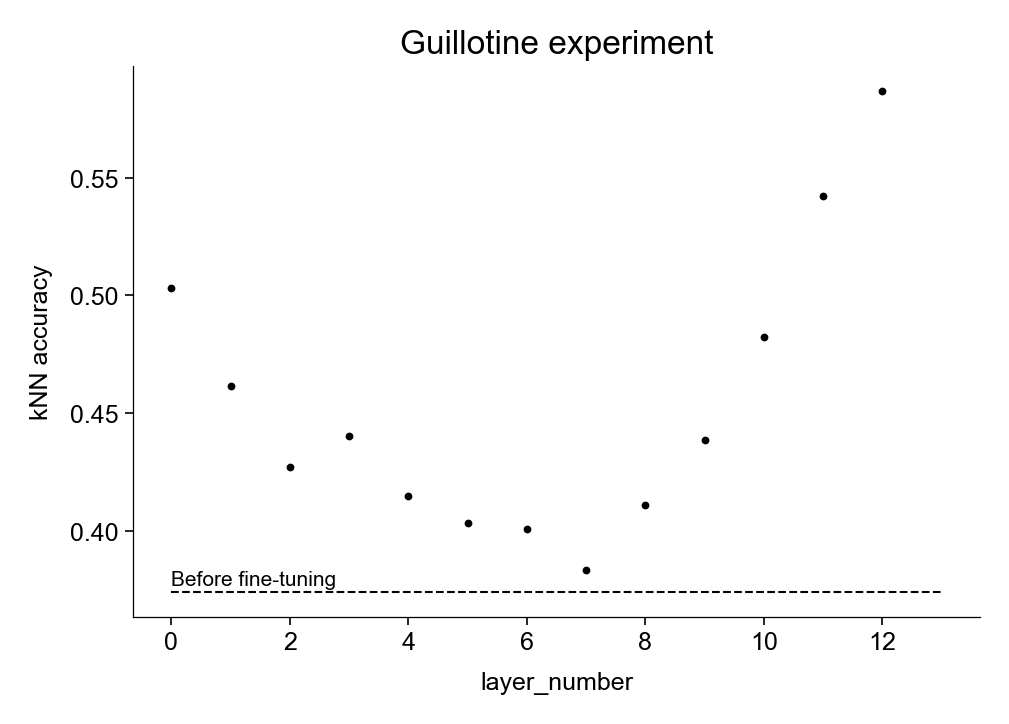

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "MPNet"
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc = np.load(
        variables_path / saving_path / saving_name,
    )
    # print(layer_number, knn_acc)

    ax.scatter(layer_number, knn_acc[0], c="k", s=3, marker=".")
# ax.hlines(0.374, 0, 12, color="r")
ax.hlines(0.374, 0, 13, color="k", linestyle="--")
ax.text(
    0,
    0.374 + 0.001,
    f"Before fine-tuning",
    fontsize=5,
    va="bottom",
    ha="left",
)
# ax.hlines(0.589, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.589 + 0.001,
#     f"After fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title("Guillotine experiment")
fig.savefig(figures_path / "guillotine_experiment_mpnet_v1.png")

In [ ]:
print(knn_acc)

[0.58692308 0.50846154 0.54384615]


### For trained (SimCSE training) model -- TO RUN

In [18]:
import torch

# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm

# from transformers import AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from text_embeddings_src.model_stuff import mean_pool

In [19]:
model_names = [
    "BERT",
    "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    #     "sentence-transformers/all-mpnet-base-v2",
    #     "allenai/scibert_scivocab_uncased",
    #     "allenai/specter",
    #     "malteos/scincl",
]

In [20]:
%%time

i = 1
model_name = model_names[i]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = SameSentencePairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("Training loader length: ", len(training_loader))



Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Training loader length:  368
CPU times: user 1min 15s, sys: 31.7 s, total: 1min 47s
Wall time: 12.1 s


In [22]:
##  train_loop_batches_eval  -- without the eval part
loader = training_loader
titles_abstracts_together = iclr2024.abstract.to_list()
# tokenizer =
label_mask = labels_iclr != "unlabeled"
labels_acc = labels_iclr[labels_iclr != "unlabeled"]
optimized_rep = "av"
n_epochs = 1
lr = 2e-5
eval_metric = "knn"
return_seventh = False

model.to(device)

# define layers to be used in multiple-negatives-ranking
cos_sim = torch.nn.CosineSimilarity()
loss_func = torch.nn.CrossEntropyLoss()
scale = 20.0  # we multiply similarity score by this scale value
# move layers to device
cos_sim.to(device)
loss_func.to(device)

# initialize Adam optimizer
optim = torch.optim.Adam(model.parameters(), lr=lr)

# setup warmup for first ~10% of steps
total_steps = len(loader) * n_epochs
warmup_steps = int(0.1 * len(loader))
scheduler = get_linear_schedule_with_warmup(
    optim,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)

losses = np.empty((n_epochs, len(loader)))

for epoch in range(n_epochs):
    model.train()  # make sure model is in training mode
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    loop = tqdm(loader, leave=True)
    for i_batch, batch in enumerate(loop):
        # zero all gradients on each new step
        optim.zero_grad()
        # prepare batches and more all to the active device
        anchor_ids = batch[0][0].to(device)
        anchor_mask = batch[0][1].to(device)
        pos_ids = batch[1][0].to(device)
        pos_mask = batch[1][1].to(device)
        # extract token embeddings from BERT
        a = model(anchor_ids, attention_mask=anchor_mask)[
            0
        ]  # all token embeddings
        p = model(pos_ids, attention_mask=pos_mask)[0]

        # get the mean pooled vectors
        if optimized_rep == "av":
            a = mean_pool(a, anchor_mask)
            p = mean_pool(p, pos_mask)

        elif optimized_rep == "cls":
            a = cls_pool(a, anchor_mask)
            p = cls_pool(p, pos_mask)

        elif optimized_rep == "sep":
            a = sep_pool(a, anchor_mask)
            p = sep_pool(p, pos_mask)

        elif optimized_rep == "7th":
            a = seventh_pool(a, anchor_mask)
            p = seventh_pool(p, pos_mask)

        # calculate the cosine similarities
        scores = torch.stack(
            [cos_sim(a_i.reshape(1, a_i.shape[0]), p) for a_i in a]
        )
        # get label(s) - we could define this before if confident
        # of consistent batch sizes
        labels = torch.tensor(
            range(len(scores)), dtype=torch.long, device=scores.device
        )
        # and now calculate the loss
        loss = loss_func(
            scores * scale, labels
        )  # Nik does not know what the labels nor the scale are
        losses[epoch, i_batch] = loss.item()

        # using loss, calculate gradients and then optimize
        loss.backward()
        optim.step()
        # update learning rate scheduler
        scheduler.step()
        # update the TDQM progress bar
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

  0%|          | 0/368 [00:00<?, ?it/s]

In [26]:
%%time
for layer_number in np.arange(13):
    print("layer number", layer_number)
    (
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = generate_embeddings_hidden_state(
        layer_number,
        iclr2024.abstract.to_list(),  # CHANGE THIS
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    knn_acc = knn_accuracy(
        [
            embedding_av[labels_iclr != "unlabeled"],
            embedding_cls[labels_iclr != "unlabeled"],
            embedding_sep[labels_iclr != "unlabeled"],
        ],
        labels_iclr[labels_iclr != "unlabeled"],
    )

    # save
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = (
        f"knn_accuracies_trained_simcse_av_after_layer_{layer_number}"
    )
    np.save(
        variables_path / saving_path / saving_name,
        knn_acc,
    )
    print(knn_acc)
    print("-----------------------")

    # save

layer number 0


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.49846154 0.03       0.05230769]
-----------------------
layer number 1


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.44615385 0.31076923 0.10846154]
-----------------------
layer number 2


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.41692308 0.21615385 0.10846154]
-----------------------
layer number 3


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.43461538 0.25076923 0.09615385]
-----------------------
layer number 4


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

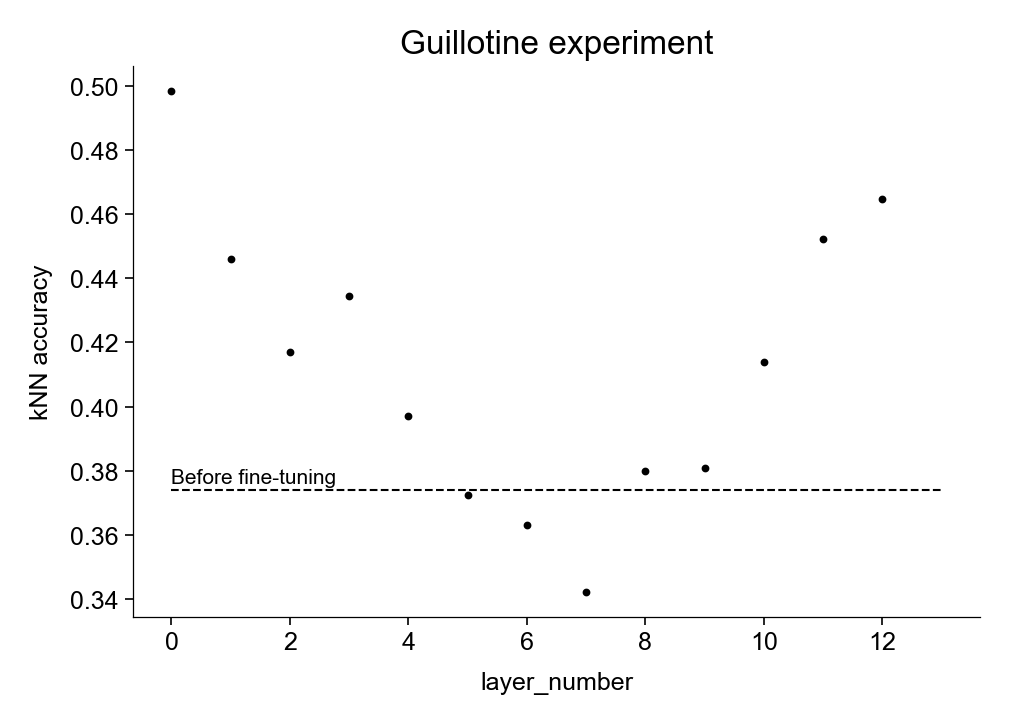

In [10]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "MPNet"
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = (
        f"knn_accuracies_trained_simcse_av_after_layer_{layer_number}.npy"
    )
    knn_acc = np.load(
        variables_path / saving_path / saving_name,
    )
    # print(layer_number, knn_acc)

    ax.scatter(layer_number, knn_acc[0], c="k", s=3, marker=".")
# ax.hlines(0.374, 0, 12, color="r")
ax.hlines(0.374, 0, 13, color="k", linestyle="--")
ax.text(
    0,
    0.374 + 0.001,
    f"Before fine-tuning",
    fontsize=5,
    va="bottom",
    ha="left",
)
# ax.hlines(0.589, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.589 + 0.001,
#     f"After fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title("Guillotine experiment")
fig.savefig(figures_path / "guillotine_experiment_mpnet_trained_simcse_v1.png")

### For untrained model

In [37]:
import torch

# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm

# from transformers import AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from text_embeddings_src.model_stuff import mean_pool

In [38]:
model_names = [
    "BERT",
    "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    #     "sentence-transformers/all-mpnet-base-v2",
    #     "allenai/scibert_scivocab_uncased",
    #     "allenai/specter",
    #     "malteos/scincl",
]

In [39]:
%%time

i = 1
model_name = model_names[i]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

model.to(device)

# # data
# training_dataset = MultOverlappingSentencesPairDataset(
#     iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
# )

# gen = torch.Generator()
# gen.manual_seed(seed)
# training_loader = torch.utils.data.DataLoader(
#     training_dataset, batch_size=64, shuffle=True, generator=gen
# )
# print("Training loader length: ", len(training_loader))



Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
CPU times: user 2.09 s, sys: 1.19 s, total: 3.28 s
Wall time: 2.28 s


MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [41]:
%%time
for layer_number in np.arange(13):
    print("layer number", layer_number)
    (
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = generate_embeddings_hidden_state(
        layer_number,
        iclr2024.abstract.to_list(),  # CHANGE THIS
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    knn_acc = knn_accuracy(
        [
            embedding_av[labels_iclr != "unlabeled"],
            embedding_cls[labels_iclr != "unlabeled"],
            embedding_sep[labels_iclr != "unlabeled"],
        ],
        labels_iclr[labels_iclr != "unlabeled"],
    )

    # save
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}"
    np.save(
        variables_path / saving_path / saving_name,
        knn_acc,
    )
    print(knn_acc)
    print("-----------------------")

    # save

layer number 0


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.49923077 0.03       0.05230769]
-----------------------
layer number 1


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.44846154 0.30230769 0.10846154]
-----------------------
layer number 2


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.40615385 0.20461538 0.11230769]
-----------------------
layer number 3


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.40384615 0.23923077 0.10923077]
-----------------------
layer number 4


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.37692308 0.23384615 0.08538462]
-----------------------
layer number 5


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.35461538 0.14       0.09538462]
-----------------------
layer number 6


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.36461538 0.13461538 0.14538462]
-----------------------
layer number 7


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.33538462 0.13384615 0.11230769]
-----------------------
layer number 8


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.33692308 0.11384615 0.11461538]
-----------------------
layer number 9


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.35076923 0.12923077 0.13230769]
-----------------------
layer number 10


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.36846154 0.16923077 0.16692308]
-----------------------
layer number 11


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.41384615 0.30307692 0.23076923]
-----------------------
layer number 12


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.37384615 0.31769231 0.36307692]
-----------------------
CPU times: user 31min 44s, sys: 43min 6s, total: 1h 14min 51s
Wall time: 45min 35s


### Plot

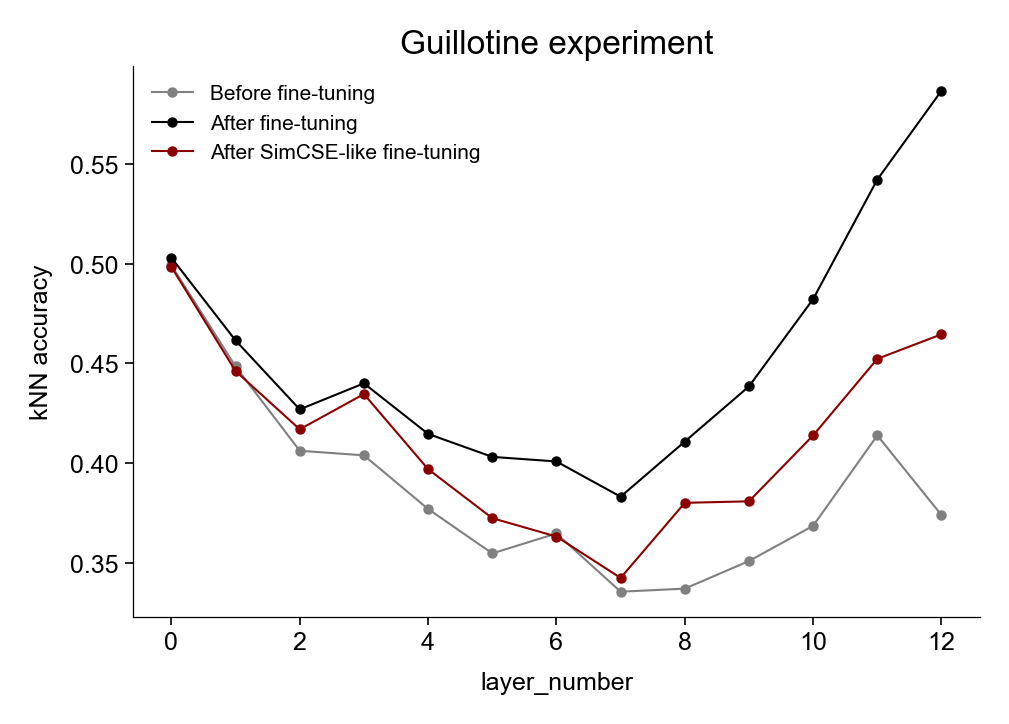

In [12]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "MPNet"
knn_acc_after_all = []
knn_acc_before_all = []
knn_acc_after_simcse_all = []
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc_after = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before = np.load(
        variables_path / saving_path / saving_name,
    )

    saving_name = (
        f"knn_accuracies_trained_simcse_av_after_layer_{layer_number}.npy"
    )
    knn_acc_after_simcse = np.load(
        variables_path / saving_path / saving_name,
    )

    knn_acc_after_all.append(knn_acc_after[0])
    knn_acc_before_all.append(knn_acc_before[0])
    knn_acc_after_simcse_all.append(knn_acc_after_simcse[0])

ax.plot(
    np.arange(13),
    knn_acc_before_all,
    c="grey",
    ms=3,
    marker=".",
    label="Before fine-tuning",
)

ax.plot(
    np.arange(13),
    knn_acc_after_all,
    c="k",
    ms=3,
    marker=".",
    label="After fine-tuning",
)

ax.plot(
    np.arange(13),
    knn_acc_after_simcse_all,
    c="darkred",
    ms=3,
    marker=".",
    label="After SimCSE-like fine-tuning",
)
ax.legend()
# ax.hlines(0.374, 0, 12, color="r")
# ax.hlines(0.374, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.374 + 0.001,
#     f"Before fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
# ax.hlines(0.589, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.589 + 0.001,
#     f"After fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title("Guillotine experiment")
fig.savefig(figures_path / "guillotine_experiment_mpnet_v4.png")

## SBERT

In [14]:
import torch

# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm

# from transformers import AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from text_embeddings_src.model_stuff import mean_pool

In [15]:
model_names = [
    # "BERT",
    # "MPNet",
    "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    # "bert-base-uncased",
    # "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    #     "allenai/scibert_scivocab_uncased",
    #     "allenai/specter",
    #     "malteos/scincl",
]

In [16]:
%%time

i = 0
model_name = model_names[i]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

model.to(device)

# # data
# training_dataset = MultOverlappingSentencesPairDataset(
#     iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
# )

# gen = torch.Generator()
# gen.manual_seed(seed)
# training_loader = torch.utils.data.DataLoader(
#     training_dataset, batch_size=64, shuffle=True, generator=gen
# )
# print("Training loader length: ", len(training_loader))



Model:  SBERT
Running on device: cuda


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence-transformers/all-mpnet-base-v2
CPU times: user 12.5 s, sys: 4.06 s, total: 16.6 s
Wall time: 15.1 s


MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [35]:
%%time
for layer_number in np.arange(13):
    print("layer number", layer_number)
    (
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = generate_embeddings_hidden_state(
        layer_number,
        iclr2024.abstract.to_list(),  # CHANGE THIS
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    knn_acc = knn_accuracy(
        [
            embedding_av[labels_iclr != "unlabeled"],
            embedding_cls[labels_iclr != "unlabeled"],
            embedding_sep[labels_iclr != "unlabeled"],
        ],
        labels_iclr[labels_iclr != "unlabeled"],
    )

    # save
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}"
    np.save(
        variables_path / saving_path / saving_name,
        knn_acc,
    )
    print(knn_acc)
    print("-----------------------")

    # save

layer number 0


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.52       0.03       0.05153846]
-----------------------
layer number 1


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.49615385 0.32       0.13230769]
-----------------------
layer number 2


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.47230769 0.24615385 0.14846154]
-----------------------
layer number 3


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.46461538 0.35538462 0.13230769]
-----------------------
layer number 4


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.46153846 0.35769231 0.12076923]
-----------------------
layer number 5


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.46307692 0.18153846 0.13923077]
-----------------------
layer number 6


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.44846154 0.22923077 0.30846154]
-----------------------
layer number 7


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.42615385 0.21923077 0.35461538]
-----------------------
layer number 8


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.45       0.24923077 0.31692308]
-----------------------
layer number 9


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.47692308 0.24230769 0.32923077]
-----------------------
layer number 10


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.53384615 0.42692308 0.42769231]
-----------------------
layer number 11


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

### Plot

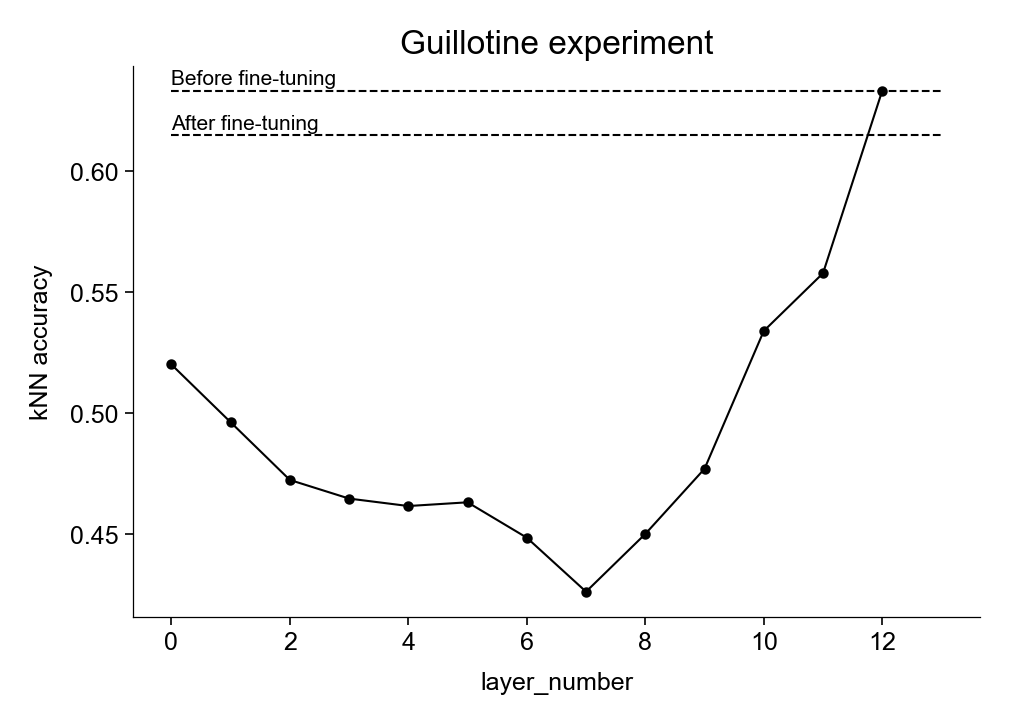

In [39]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "SBERT"
knn_acc_all = []
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )

    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc = np.load(
        variables_path / saving_path / saving_name,
    )

    knn_acc_all.append(knn_acc[0])

ax.plot(
    np.arange(13),
    knn_acc_all,
    c="k",
    ms=3,
    marker=".",
)

# load before and after training value
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

losses = np.load(variables_path / saving_path / "losses_run1.npy")
knn_accuracies_after = np.load(
    variables_path / saving_path / "knn_accuracies_run1.npy"
)

saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_accuracies_before = np.load(
    variables_path / "updated_dataset" / saving_name_2
)
ax.hlines(knn_accuracies_before[0], 0, 13, color="k", linestyle="--")
ax.text(
    0,
    knn_accuracies_before[0] + 0.001,
    f"Before fine-tuning",
    fontsize=5,
    va="bottom",
    ha="left",
)
ax.hlines(knn_accuracies_after[0, 0], 0, 13, color="k", linestyle="--")
ax.text(
    0,
    knn_accuracies_after[0, 0] + 0.001,
    f"After fine-tuning",
    fontsize=5,
    va="bottom",
    ha="left",
)

ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title("Guillotine experiment")
fig.savefig(
    figures_path / f"guillotine_experiment_{model_name.lower()}_v1.png"
)

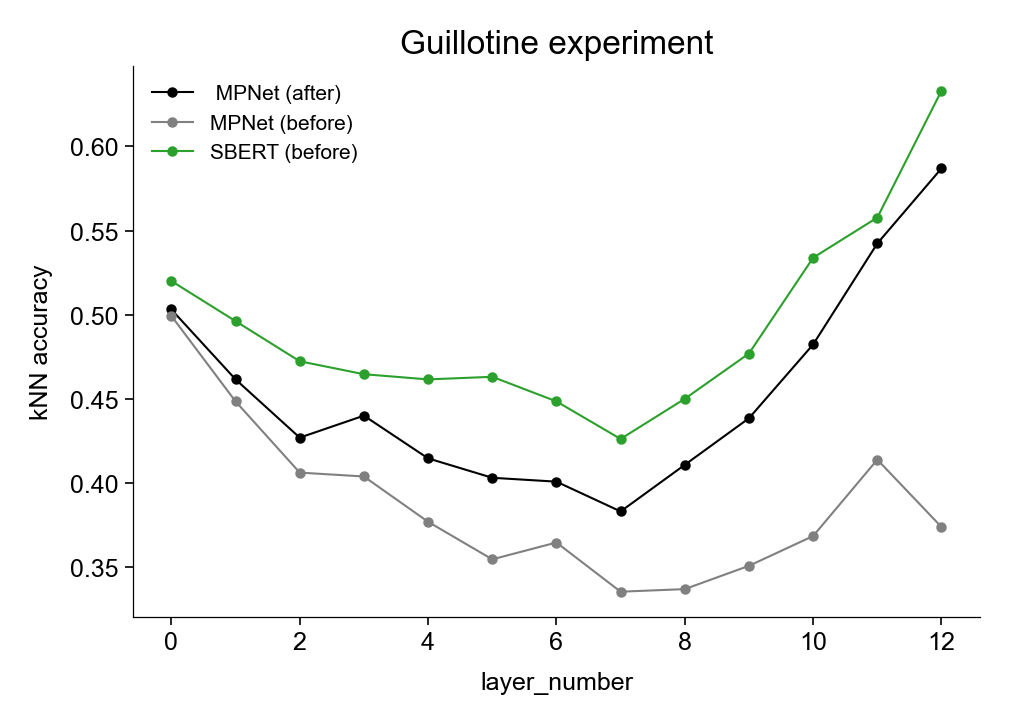

In [40]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")


knn_acc_after_all_mpnet = []
knn_acc_before_all_mpnet = []
knn_acc_before_all_sbert = []
for layer_number in np.arange(13):
    # load MPNet
    model_name = "MPNet"
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc_after_mpnet = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before_mpnet = np.load(
        variables_path / saving_path / saving_name,
    )
    # load SBERT
    model_name = "SBERT"
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )

    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before_sbert = np.load(
        variables_path / saving_path / saving_name,
    )

    # concatenate
    knn_acc_after_all_mpnet.append(knn_acc_after_mpnet[0])
    knn_acc_before_all_mpnet.append(knn_acc_before_mpnet[0])
    knn_acc_before_all_sbert.append(knn_acc_before_sbert[0])

ax.plot(
    np.arange(13),
    knn_acc_after_all_mpnet,
    c="k",
    ms=3,
    marker=".",
    label=" MPNet (after)",
)
ax.plot(
    np.arange(13),
    knn_acc_before_all_mpnet,
    c="grey",
    ms=3,
    marker=".",
    label="MPNet (before)",
)

ax.plot(
    np.arange(13),
    knn_acc_before_all_sbert,
    c="tab:green",
    ms=3,
    marker=".",
    label="SBERT (before)",
)
ax.legend()

ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title("Guillotine experiment")
fig.savefig(figures_path / "guillotine_experiment_several_models_v1.png")

## Random model

### For untrained model

In [ ]:
# # USE IN THE FUTURE FOR RANDOM SEED
# import torch
# import numpy as np
# import random

# def seed_everything(seed):
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
#     torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.deterministic = True
#     # torch.use_deterministic_algorithms(True)
#     np.random.seed(seed)  # Numpy module.
#     random.seed(seed)  # Python random module.


In [ ]:
# # COMPARE TO THIS MODEL IF IT IS NOT REPRODUCIBLE
# from transformers import BertConfig, BertModel

# # Define the configuration for the BERT model
# config = BertConfig.from_pretrained("bert-base-uncased")

# # Modify the configuration to initialize weights randomly
# for param in config.__dict__.values():
#     if isinstance(param, int):
#         param = np.random.randint(low=-10, high=10, size=(param,))
#     elif isinstance(param, float):
#         param = np.random.uniform(low=-1.0, high=1.0, size=(param,))

# # Create the BERT model with the modified configuration
# model = BertModel(config)

#### First seed

In [50]:
%%time

from transformers import BertConfig, BertModel

model_name = "random_bert"
## fix random seeds
### old runs
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

### what I tried in the first run now
# random_state = random.seed(42)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config

model = model.to(device)

Model:  random_bert
Running on device: cuda
CPU times: user 1.37 s, sys: 32.5 ms, total: 1.4 s
Wall time: 1.52 s


In [51]:
%%time
for layer_number in np.arange(13):
    print("layer number", layer_number)
    (
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = generate_embeddings_hidden_state(
        layer_number,
        iclr2024.abstract.to_list(),  # CHANGE THIS
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    knn_acc = knn_accuracy(
        [
            embedding_av[labels_iclr != "unlabeled"],
            embedding_cls[labels_iclr != "unlabeled"],
            embedding_sep[labels_iclr != "unlabeled"],
        ],
        labels_iclr[labels_iclr != "unlabeled"],
    )

    # save
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}_v1"
    np.save(
        variables_path / saving_path / saving_name,
        knn_acc,
    )
    print(knn_acc)
    print("-----------------------")

    # save

layer number 0


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.39461538 0.03       0.05307692]
-----------------------
layer number 1


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.38076923 0.34538462 0.10923077]
-----------------------
layer number 2


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.38384615 0.35538462 0.10846154]
-----------------------
layer number 3


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.35769231 0.36       0.10615385]
-----------------------
layer number 4


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.36230769 0.33846154 0.11076923]
-----------------------
layer number 5


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.34846154 0.33384615 0.10769231]
-----------------------
layer number 6


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.33923077 0.33615385 0.10615385]
-----------------------
layer number 7


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.34153846 0.32538462 0.10076923]
-----------------------
layer number 8


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.33538462 0.31       0.09153846]
-----------------------
layer number 9


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.32384615 0.31923077 0.09384615]
-----------------------
layer number 10


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.31461538 0.31076923 0.09307692]
-----------------------
layer number 11


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.31230769 0.30461538 0.10076923]
-----------------------
layer number 12


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.30538462 0.30461538 0.09769231]
-----------------------
CPU times: user 21min 52s, sys: 40min 34s, total: 1h 2min 27s
Wall time: 42min 20s


#### Second seed

In [21]:
%%time

from transformers import BertConfig, BertModel

model_name = "random_bert"
## fix random seeds
### old runs
seed = 23
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

### what I tried in the first run now
# random_state = random.seed(42)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config

model = model.to(device)

Model:  random_bert
Running on device: cuda
CPU times: user 1.39 s, sys: 55.8 ms, total: 1.44 s
Wall time: 1.56 s


In [22]:
%%time
for layer_number in np.arange(13):
    print("layer number", layer_number)
    (
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = generate_embeddings_hidden_state(
        layer_number,
        iclr2024.abstract.to_list(),  # CHANGE THIS
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    knn_acc = knn_accuracy(
        [
            embedding_av[labels_iclr != "unlabeled"],
            embedding_cls[labels_iclr != "unlabeled"],
            embedding_sep[labels_iclr != "unlabeled"],
        ],
        labels_iclr[labels_iclr != "unlabeled"],
    )

    # save
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}_v2"
    np.save(
        variables_path / saving_path / saving_name,
        knn_acc,
    )
    print(knn_acc)
    print("-----------------------")

    # save

layer number 0


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.41384615 0.03       0.05307692]
-----------------------
layer number 1


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.41230769 0.35307692 0.10846154]
-----------------------
layer number 2


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.4        0.37153846 0.10615385]
-----------------------
layer number 3


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.38461538 0.36       0.10692308]
-----------------------
layer number 4


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.38230769 0.37461538 0.10384615]
-----------------------
layer number 5


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.35384615 0.35692308 0.10769231]
-----------------------
layer number 6


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.35230769 0.36615385 0.10769231]
-----------------------
layer number 7


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.34538462 0.35615385 0.09923077]
-----------------------
layer number 8


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.33230769 0.34615385 0.09461538]
-----------------------
layer number 9


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.32384615 0.34307692 0.09615385]
-----------------------
layer number 10


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.31923077 0.34153846 0.09615385]
-----------------------
layer number 11


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.30307692 0.33076923 0.08846154]
-----------------------
layer number 12


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.29846154 0.32307692 0.09615385]
-----------------------
CPU times: user 20min 47s, sys: 40min 7s, total: 1h 55s
Wall time: 42min 14s


#### Third seed

In [23]:
%%time

from transformers import BertConfig, BertModel

model_name = "random_bert"
## fix random seeds
### old runs
seed = 12
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

### what I tried in the first run now
# random_state = random.seed(42)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config

model = model.to(device)

Model:  random_bert
Running on device: cuda
CPU times: user 1.35 s, sys: 53.8 ms, total: 1.4 s
Wall time: 1.56 s


In [24]:
%%time
for layer_number in np.arange(13):
    print("layer number", layer_number)
    (
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = generate_embeddings_hidden_state(
        layer_number,
        iclr2024.abstract.to_list(),  # CHANGE THIS
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    knn_acc = knn_accuracy(
        [
            embedding_av[labels_iclr != "unlabeled"],
            embedding_cls[labels_iclr != "unlabeled"],
            embedding_sep[labels_iclr != "unlabeled"],
        ],
        labels_iclr[labels_iclr != "unlabeled"],
    )

    # save
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}_v3"
    np.save(
        variables_path / saving_path / saving_name,
        knn_acc,
    )
    print(knn_acc)
    print("-----------------------")

    # save

layer number 0


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.40769231 0.03       0.05076923]
-----------------------
layer number 1


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.38538462 0.34538462 0.10538462]
-----------------------
layer number 2


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.37615385 0.36384615 0.09692308]
-----------------------
layer number 3


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.37230769 0.35615385 0.10769231]
-----------------------
layer number 4


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.36230769 0.34       0.11153846]
-----------------------
layer number 5


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.36923077 0.34153846 0.11      ]
-----------------------
layer number 6


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.36615385 0.35153846 0.11538462]
-----------------------
layer number 7


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.35461538 0.35230769 0.10384615]
-----------------------
layer number 8


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.35153846 0.33461538 0.10461538]
-----------------------
layer number 9


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.33846154 0.34230769 0.10076923]
-----------------------
layer number 10


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.32923077 0.32307692 0.10384615]
-----------------------
layer number 11


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.32692308 0.31923077 0.10384615]
-----------------------
layer number 12


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.32692308 0.31307692 0.10076923]
-----------------------
CPU times: user 21min 29s, sys: 40min 7s, total: 1h 1min 37s
Wall time: 42min 15s


#### Plot

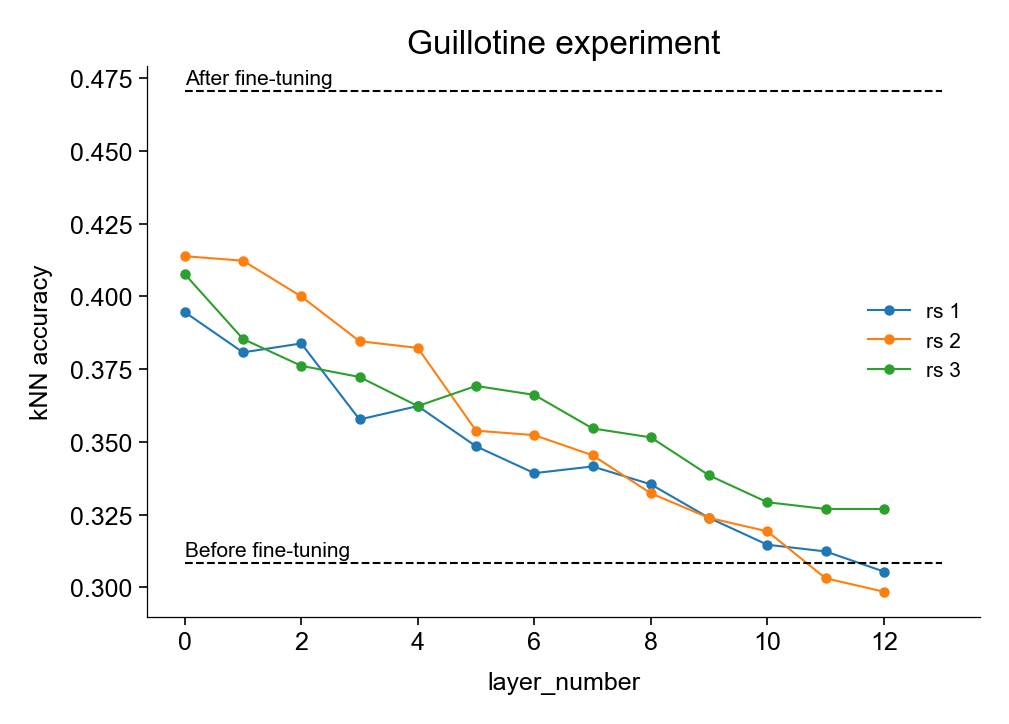

In [27]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "random_bert"
knn_acc_all_v1 = []
knn_acc_all_v2 = []
knn_acc_all_v3 = []
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    # first seed
    saving_name = (
        f"knn_accuracies_untrained_av_after_layer_{layer_number}_v1.npy"
    )
    knn_acc = np.load(
        variables_path / saving_path / saving_name,
    )

    knn_acc_all_v1.append(knn_acc[0])

    # second seed
    saving_name = (
        f"knn_accuracies_untrained_av_after_layer_{layer_number}_v2.npy"
    )
    knn_acc = np.load(
        variables_path / saving_path / saving_name,
    )

    knn_acc_all_v2.append(knn_acc[0])

    # third seed
    saving_name = (
        f"knn_accuracies_untrained_av_after_layer_{layer_number}_v3.npy"
    )
    knn_acc = np.load(
        variables_path / saving_path / saving_name,
    )

    knn_acc_all_v3.append(knn_acc[0])

ax.plot(
    np.arange(13),
    knn_acc_all_v1,
    # c="k",
    ms=3,
    marker=".",
    label="rs 1",
)

ax.plot(
    np.arange(13),
    knn_acc_all_v2,
    # c="k",
    ms=3,
    marker=".",
    label="rs 2",
)

ax.plot(
    np.arange(13),
    knn_acc_all_v3,
    # c="k",
    ms=3,
    marker=".",
    label="rs 3",
)
# load before and after training value
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

losses = np.load(variables_path / saving_path / "losses_run1.npy")
knn_accuracies_after = np.load(
    variables_path / saving_path / "knn_accuracies_run1.npy"
)

saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_accuracies_before = np.load(
    variables_path / "updated_dataset" / saving_name_2
)
ax.hlines(knn_accuracies_before[0], 0, 13, color="k", linestyle="--")
ax.text(
    0,
    knn_accuracies_before[0] + 0.001,
    f"Before fine-tuning",
    fontsize=5,
    va="bottom",
    ha="left",
)
ax.hlines(knn_accuracies_after[0, 0], 0, 13, color="k", linestyle="--")
ax.text(
    0,
    knn_accuracies_after[0, 0] + 0.001,
    f"After fine-tuning",
    fontsize=5,
    va="bottom",
    ha="left",
)
ax.legend(loc="center right")
ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title("Guillotine experiment")
fig.savefig(
    figures_path / f"guillotine_experiment_{model_name.lower()}_before_v2.png"
)

### For trained model (1 epoch)

In [16]:
import torch

# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm

# from transformers import AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from text_embeddings_src.model_stuff import mean_pool

In [18]:
%%time

from transformers import BertConfig, BertModel

model_name = "random_bert"
## fix random seeds -- I CHANGED THIS ALREADY

### old runs
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

### what I tried in the first run now
# random_state = random.seed(42)

# set up model
print("Model: ", model_name)


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config

model = model.to(device)

# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("Training loader length: ", len(training_loader))

Model:  random_bert
Running on device: cuda
Training loader length:  368
CPU times: user 1min 20s, sys: 28.3 s, total: 1min 48s
Wall time: 17.1 s


In [19]:
##  train_loop_batches_eval
loader = training_loader
titles_abstracts_together = iclr2024.abstract.to_list()
# tokenizer =
label_mask = labels_iclr != "unlabeled"
labels_acc = labels_iclr[labels_iclr != "unlabeled"]
optimized_rep = "av"
n_epochs = 1
lr = 2e-5
eval_metric = "knn"
return_seventh = False

model.to(device)

# define layers to be used in multiple-negatives-ranking
cos_sim = torch.nn.CosineSimilarity()
loss_func = torch.nn.CrossEntropyLoss()
scale = 20.0  # we multiply similarity score by this scale value
# move layers to device
cos_sim.to(device)
loss_func.to(device)

# initialize Adam optimizer
optim = torch.optim.Adam(model.parameters(), lr=lr)

# setup warmup for first ~10% of steps
total_steps = len(loader) * n_epochs
warmup_steps = int(0.1 * len(loader))
scheduler = get_linear_schedule_with_warmup(
    optim,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)

losses = np.empty((n_epochs, len(loader)))

for epoch in range(n_epochs):
    model.train()  # make sure model is in training mode
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    loop = tqdm(loader, leave=True)
    for i_batch, batch in enumerate(loop):
        # zero all gradients on each new step
        optim.zero_grad()
        # prepare batches and more all to the active device
        anchor_ids = batch[0][0].to(device)
        anchor_mask = batch[0][1].to(device)
        pos_ids = batch[1][0].to(device)
        pos_mask = batch[1][1].to(device)
        # extract token embeddings from BERT
        a = model(anchor_ids, attention_mask=anchor_mask)[
            0
        ]  # all token embeddings
        p = model(pos_ids, attention_mask=pos_mask)[0]

        # get the mean pooled vectors
        if optimized_rep == "av":
            a = mean_pool(a, anchor_mask)
            p = mean_pool(p, pos_mask)

        elif optimized_rep == "cls":
            a = cls_pool(a, anchor_mask)
            p = cls_pool(p, pos_mask)

        elif optimized_rep == "sep":
            a = sep_pool(a, anchor_mask)
            p = sep_pool(p, pos_mask)

        elif optimized_rep == "7th":
            a = seventh_pool(a, anchor_mask)
            p = seventh_pool(p, pos_mask)

        # calculate the cosine similarities
        scores = torch.stack(
            [cos_sim(a_i.reshape(1, a_i.shape[0]), p) for a_i in a]
        )
        # get label(s) - we could define this before if confident
        # of consistent batch sizes
        labels = torch.tensor(
            range(len(scores)), dtype=torch.long, device=scores.device
        )
        # and now calculate the loss
        loss = loss_func(
            scores * scale, labels
        )  # Nik does not know what the labels nor the scale are
        losses[epoch, i_batch] = loss.item()

        # using loss, calculate gradients and then optimize
        loss.backward()
        optim.step()
        # update learning rate scheduler
        scheduler.step()
        # update the TDQM progress bar
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

  0%|          | 0/368 [00:00<?, ?it/s]

In [20]:
%%time
for layer_number in np.arange(13):
    print("layer number", layer_number)
    (
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = generate_embeddings_hidden_state(
        layer_number,
        iclr2024.abstract.to_list(),  # CHANGE THIS
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    knn_acc = knn_accuracy(
        [
            embedding_av[labels_iclr != "unlabeled"],
            embedding_cls[labels_iclr != "unlabeled"],
            embedding_sep[labels_iclr != "unlabeled"],
        ],
        labels_iclr[labels_iclr != "unlabeled"],
    )

    # save
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = (
        f"knn_accuracies_trained_n_epochs_1_av_after_layer_{layer_number}"
    )
    np.save(
        variables_path / saving_path / saving_name,
        knn_acc,
    )
    print(knn_acc)
    print("-----------------------")

    # save

layer number 0


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.40692308 0.03       0.05      ]
-----------------------
layer number 1


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.41       0.36846154 0.11615385]
-----------------------
layer number 2


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.41461538 0.39538462 0.11307692]
-----------------------
layer number 3


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.40153846 0.38076923 0.12692308]
-----------------------
layer number 4


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.40923077 0.39923077 0.13384615]
-----------------------
layer number 5


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.41923077 0.40384615 0.13615385]
-----------------------
layer number 6


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.41692308 0.40769231 0.13      ]
-----------------------
layer number 7


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.43615385 0.40615385 0.14692308]
-----------------------
layer number 8


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.45       0.41       0.14846154]
-----------------------
layer number 9


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.45153846 0.41846154 0.15      ]
-----------------------
layer number 10


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.45461538 0.42384615 0.15846154]
-----------------------
layer number 11


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.44923077 0.42615385 0.16692308]
-----------------------
layer number 12


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.44846154 0.42153846 0.17153846]
-----------------------
CPU times: user 21min 18s, sys: 40min 24s, total: 1h 1min 42s
Wall time: 42min 25s


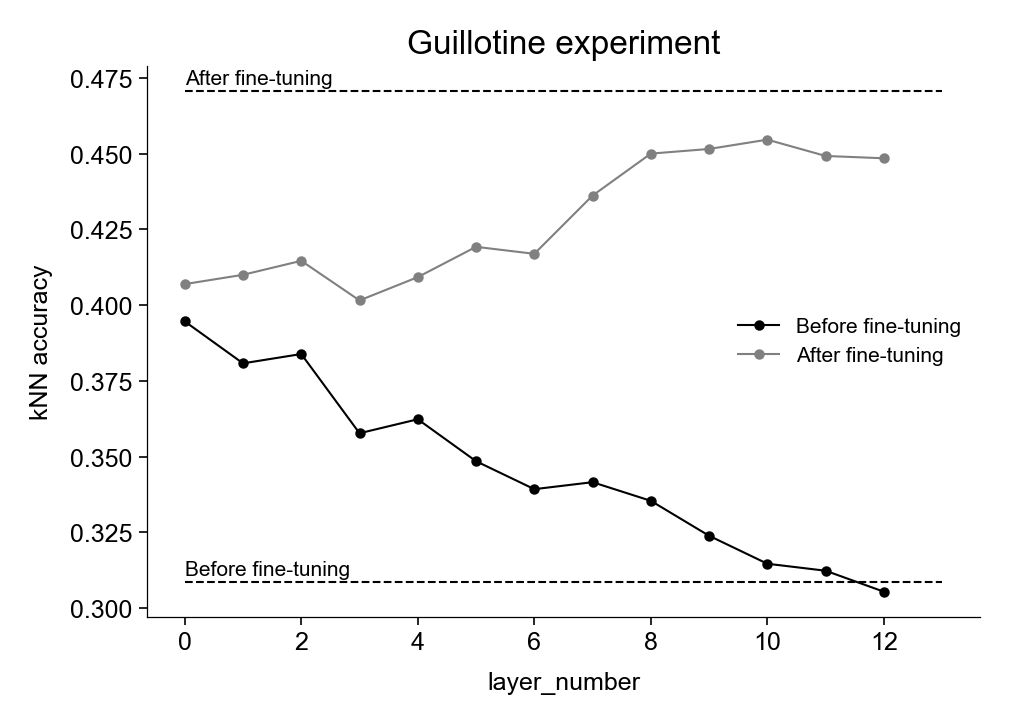

In [22]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "random_bert"
knn_acc_before_all = []
knn_acc_after_all = []
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    saving_name = (
        f"knn_accuracies_untrained_av_after_layer_{layer_number}_v1.npy"
    )
    knn_acc_before = np.load(
        variables_path / saving_path / saving_name,
    )

    knn_acc_before_all.append(knn_acc_before[0])

    saving_name = (
        f"knn_accuracies_trained_n_epochs_1_av_after_layer_{layer_number}.npy"
    )
    knn_acc_after = np.load(
        variables_path / saving_path / saving_name,
    )

    knn_acc_after_all.append(knn_acc_after[0])

ax.plot(
    np.arange(13),
    knn_acc_before_all,
    c="k",
    ms=3,
    marker=".",
    label="Before fine-tuning",
)

ax.plot(
    np.arange(13),
    knn_acc_after_all,
    c="grey",
    ms=3,
    marker=".",
    label="After fine-tuning",
)

# load before and after training value
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

knn_accuracies_after = np.load(
    variables_path / saving_path / "knn_accuracies_run1.npy"
)

saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_accuracies_before = np.load(
    variables_path / "updated_dataset" / saving_name_2
)
ax.hlines(knn_accuracies_before[0], 0, 13, color="k", linestyle="--")
ax.text(
    0,
    knn_accuracies_before[0] + 0.001,
    f"Before fine-tuning",
    fontsize=5,
    va="bottom",
    ha="left",
)
ax.hlines(knn_accuracies_after[0, 0], 0, 13, color="k", linestyle="--")
ax.text(
    0,
    knn_accuracies_after[0, 0] + 0.001,
    f"After fine-tuning",
    fontsize=5,
    va="bottom",
    ha="left",
)
ax.legend(loc="center right")
ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title("Guillotine experiment")
fig.savefig(
    figures_path
    / f"guillotine_experiment_{model_name.lower()}_after_n_epochs_1_v1.png"
)

### For trained model (10 epoch) -- STILL TO RUN

In [16]:
import torch

# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm

# from transformers import AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from text_embeddings_src.model_stuff import mean_pool

In [17]:
%%time

from transformers import BertConfig, BertModel

model_name = "random_bert"
## fix random seeds -- I CHANGED THIS ALREADY

### old runs
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

### what I tried in the first run now
# random_state = random.seed(42)

# set up model
print("Model: ", model_name)


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## randomly initialized model
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()
# Initializing a model (with random weights) from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config

model = model.to(device)

# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("Training loader length: ", len(training_loader))

Model:  random_bert
Running on device: cuda
Training loader length:  368
CPU times: user 1min 17s, sys: 26.5 s, total: 1min 43s
Wall time: 16.2 s


In [18]:
##  train_loop_batches_eval
loader = training_loader
titles_abstracts_together = iclr2024.abstract.to_list()
# tokenizer =
label_mask = labels_iclr != "unlabeled"
labels_acc = labels_iclr[labels_iclr != "unlabeled"]
optimized_rep = "av"
n_epochs = 10
lr = 2e-5
eval_metric = "knn"
return_seventh = False

model.to(device)

# define layers to be used in multiple-negatives-ranking
cos_sim = torch.nn.CosineSimilarity()
loss_func = torch.nn.CrossEntropyLoss()
scale = 20.0  # we multiply similarity score by this scale value
# move layers to device
cos_sim.to(device)
loss_func.to(device)

# initialize Adam optimizer
optim = torch.optim.Adam(model.parameters(), lr=lr)

# setup warmup for first ~10% of steps
total_steps = len(loader) * n_epochs
warmup_steps = int(0.1 * len(loader))
scheduler = get_linear_schedule_with_warmup(
    optim,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)

losses = np.empty((n_epochs, len(loader)))

for epoch in range(n_epochs):
    model.train()  # make sure model is in training mode
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    loop = tqdm(loader, leave=True)
    for i_batch, batch in enumerate(loop):
        # zero all gradients on each new step
        optim.zero_grad()
        # prepare batches and more all to the active device
        anchor_ids = batch[0][0].to(device)
        anchor_mask = batch[0][1].to(device)
        pos_ids = batch[1][0].to(device)
        pos_mask = batch[1][1].to(device)
        # extract token embeddings from BERT
        a = model(anchor_ids, attention_mask=anchor_mask)[
            0
        ]  # all token embeddings
        p = model(pos_ids, attention_mask=pos_mask)[0]

        # get the mean pooled vectors
        if optimized_rep == "av":
            a = mean_pool(a, anchor_mask)
            p = mean_pool(p, pos_mask)

        elif optimized_rep == "cls":
            a = cls_pool(a, anchor_mask)
            p = cls_pool(p, pos_mask)

        elif optimized_rep == "sep":
            a = sep_pool(a, anchor_mask)
            p = sep_pool(p, pos_mask)

        elif optimized_rep == "7th":
            a = seventh_pool(a, anchor_mask)
            p = seventh_pool(p, pos_mask)

        # calculate the cosine similarities
        scores = torch.stack(
            [cos_sim(a_i.reshape(1, a_i.shape[0]), p) for a_i in a]
        )
        # get label(s) - we could define this before if confident
        # of consistent batch sizes
        labels = torch.tensor(
            range(len(scores)), dtype=torch.long, device=scores.device
        )
        # and now calculate the loss
        loss = loss_func(
            scores * scale, labels
        )  # Nik does not know what the labels nor the scale are
        losses[epoch, i_batch] = loss.item()

        # using loss, calculate gradients and then optimize
        loss.backward()
        optim.step()
        # update learning rate scheduler
        scheduler.step()
        # update the TDQM progress bar
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

In [19]:
%%time
for layer_number in np.arange(13):
    print("layer number", layer_number)
    (
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = generate_embeddings_hidden_state(
        layer_number,
        iclr2024.abstract.to_list(),  # CHANGE THIS
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    knn_acc = knn_accuracy(
        [
            embedding_av[labels_iclr != "unlabeled"],
            embedding_cls[labels_iclr != "unlabeled"],
            embedding_sep[labels_iclr != "unlabeled"],
        ],
        labels_iclr[labels_iclr != "unlabeled"],
    )

    # save
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = (
        f"knn_accuracies_trained_n_epochs_10_av_after_layer_{layer_number}"
    )
    np.save(
        variables_path / saving_path / saving_name,
        knn_acc,
    )
    print(knn_acc)
    print("-----------------------")

    # save

layer number 0


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.46923077 0.03       0.05076923]
-----------------------
layer number 1


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.49615385 0.49076923 0.17769231]
-----------------------
layer number 2


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.51923077 0.50846154 0.19384615]
-----------------------
layer number 3


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.53923077 0.51846154 0.20076923]
-----------------------
layer number 4


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.55076923 0.52       0.20692308]
-----------------------
layer number 5


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.55846154 0.52769231 0.21076923]
-----------------------
layer number 6


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.56692308 0.53153846 0.20923077]
-----------------------
layer number 7


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.55923077 0.54307692 0.21230769]
-----------------------
layer number 8


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.56153846 0.53846154 0.21923077]
-----------------------
layer number 9


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.55923077 0.53461538 0.22230769]
-----------------------
layer number 10


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.56846154 0.53384615 0.21692308]
-----------------------
layer number 11


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.57846154 0.53769231 0.21769231]
-----------------------
layer number 12


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.57076923 0.53769231 0.22461538]
-----------------------
CPU times: user 20min 43s, sys: 40min 42s, total: 1h 1min 25s
Wall time: 42min 17s


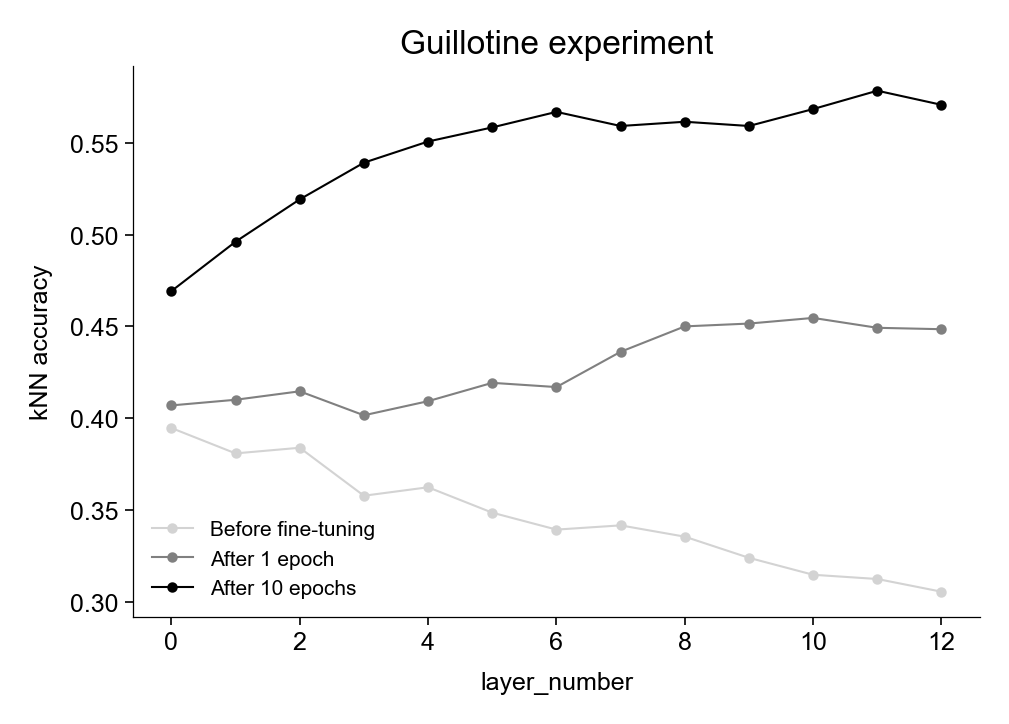

In [24]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "random_bert"
knn_acc_before_all = []
knn_acc_after_all = []
knn_acc_after_10_all = []
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    saving_name = (
        f"knn_accuracies_untrained_av_after_layer_{layer_number}_v1.npy"
    )
    knn_acc_before = np.load(
        variables_path / saving_path / saving_name,
    )

    knn_acc_before_all.append(knn_acc_before[0])

    saving_name = (
        f"knn_accuracies_trained_n_epochs_1_av_after_layer_{layer_number}.npy"
    )
    knn_acc_after = np.load(
        variables_path / saving_path / saving_name,
    )

    knn_acc_after_all.append(knn_acc_after[0])

    saving_name = (
        f"knn_accuracies_trained_n_epochs_10_av_after_layer_{layer_number}.npy"
    )
    knn_acc_after_10 = np.load(
        variables_path / saving_path / saving_name,
    )

    knn_acc_after_10_all.append(knn_acc_after_10[0])

ax.plot(
    np.arange(13),
    knn_acc_before_all,
    c="lightgrey",
    ms=3,
    marker=".",
    label="Before fine-tuning",
)

ax.plot(
    np.arange(13),
    knn_acc_after_all,
    c="grey",
    ms=3,
    marker=".",
    label="After 1 epoch",
)

ax.plot(
    np.arange(13),
    knn_acc_after_10_all,
    c="k",
    ms=3,
    marker=".",
    label="After 10 epochs",
)

# # load before and after training value
# saving_path = Path("embeddings_" + model_name.lower()) / Path(
#     "updated_dataset"
# )

# knn_accuracies_after = np.load(
#     variables_path / saving_path / "knn_accuracies_run1.npy"
# )

# saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
# knn_accuracies_before = np.load(
#     variables_path / "updated_dataset" / saving_name_2
# )
# ax.hlines(knn_accuracies_before[0], 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     knn_accuracies_before[0] + 0.001,
#     f"Before fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
# ax.hlines(knn_accuracies_after[0, 0], 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     knn_accuracies_after[0, 0] + 0.001,
#     f"After fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
ax.legend()  # loc="center right")
ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title("Guillotine experiment")
fig.savefig(
    figures_path
    / f"guillotine_experiment_{model_name.lower()}_after_n_epochs_10_v1.png"
)

## Global plot

In [21]:
# tab10 colors
tab10_colors = {
    "tab:blue": "#1f77b4",
    "tab:orange": "#ff7f0e",
    "tab:green": "#2ca02c",
    "tab:red": "#d62728",
    "tab:purple": "#9467bd",
    "tab:brown": "#8c564b",
    "tab:pink": "#e377c2",
    "tab:gray": "#7f7f7f",
    "tab:olive": "#bcbd22",
    "tab:cyan": "#17becf",
}

tab10_colors_light = {
    "tab:blue": "#7fbee9",
    "tab:orange": "#ffbf86",
    "tab:green": "#87de87",
    "tab:red": "#eb9293",
    "tab:purple": "#c9b3de",
    "tab:brown": "#cca69f",
    "tab:pink": "#f1bbe0",
    "tab:gray": "#bfbfbf",
    "tab:olive": "#e8e985",
    "tab:cyan": "#81e7f1",
}

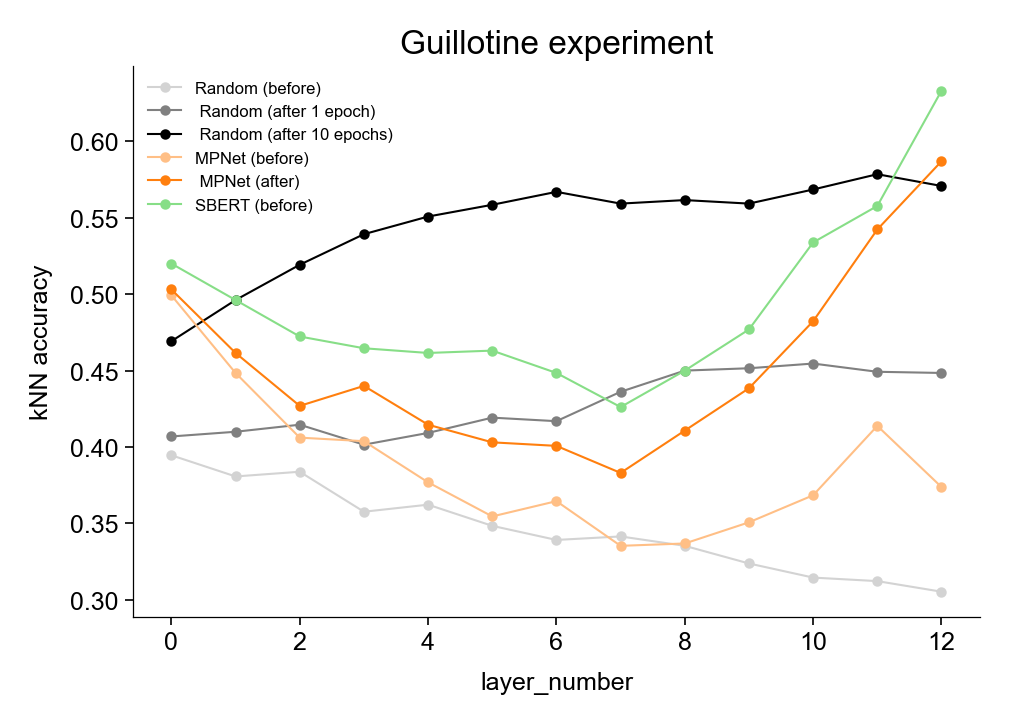

In [28]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")


knn_acc_after_all_mpnet = []
knn_acc_before_all_mpnet = []
knn_acc_before_all_sbert = []
knn_acc_before_all_random = []
knn_acc_after_all_random = []
knn_acc_after_10_all_random = []
for layer_number in np.arange(13):
    # load MPNet
    model_name = "MPNet"
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc_after_mpnet = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before_mpnet = np.load(
        variables_path / saving_path / saving_name,
    )
    # load SBERT
    model_name = "SBERT"
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )

    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before_sbert = np.load(
        variables_path / saving_path / saving_name,
    )

    # load random BERT
    model_name = "random_bert"
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    saving_name = (
        f"knn_accuracies_untrained_av_after_layer_{layer_number}_v1.npy"
    )
    knn_acc_before_random = np.load(
        variables_path / saving_path / saving_name,
    )

    saving_name = (
        f"knn_accuracies_trained_n_epochs_1_av_after_layer_{layer_number}.npy"
    )
    knn_acc_after_random = np.load(
        variables_path / saving_path / saving_name,
    )

    saving_name = (
        f"knn_accuracies_trained_n_epochs_10_av_after_layer_{layer_number}.npy"
    )
    knn_acc_after_10_random = np.load(
        variables_path / saving_path / saving_name,
    )

    # concatenate
    knn_acc_after_all_mpnet.append(knn_acc_after_mpnet[0])
    knn_acc_before_all_mpnet.append(knn_acc_before_mpnet[0])
    knn_acc_before_all_sbert.append(knn_acc_before_sbert[0])
    knn_acc_before_all_random.append(knn_acc_before_random[0])
    knn_acc_after_all_random.append(knn_acc_after_random[0])
    knn_acc_after_10_all_random.append(knn_acc_after_10_random[0])

ax.plot(
    np.arange(13),
    knn_acc_before_all_random,
    c="lightgrey",
    ms=3,
    marker=".",
    label="Random (before)",
)
ax.plot(
    np.arange(13),
    knn_acc_after_all_random,
    c="grey",
    ms=3,
    marker=".",
    label=" Random (after 1 epoch)",
)
ax.plot(
    np.arange(13),
    knn_acc_after_10_all_random,
    c="k",
    ms=3,
    marker=".",
    label=" Random (after 10 epochs)",
)
ax.plot(
    np.arange(13),
    knn_acc_before_all_mpnet,
    c=tab10_colors_light["tab:orange"],
    ms=3,
    marker=".",
    label="MPNet (before)",
)
ax.plot(
    np.arange(13),
    knn_acc_after_all_mpnet,
    c=tab10_colors["tab:orange"],
    ms=3,
    marker=".",
    label=" MPNet (after)",
)

ax.plot(
    np.arange(13),
    knn_acc_before_all_sbert,
    c=tab10_colors_light["tab:green"],
    ms=3,
    marker=".",
    label="SBERT (before)",
)


ax.legend(fontsize=4)

ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title("Guillotine experiment")
fig.savefig(figures_path / "guillotine_experiment_several_models_v3.png")

# Guillotine Reddit

## Import Reddit

In [12]:
dataset_name = "reddit"
dataset_path = "mteb/reddit-clustering-p2p"

In [13]:
dataset = load_dataset(dataset_path)

In [14]:
dataset

DatasetDict({
    test: Dataset({
        features: ['sentences', 'labels'],
        num_rows: 10
    })
})

In [15]:
sentences = list(
    np.hstack(dataset.data["test"].to_pandas().sentences.to_numpy())
)
labels_reddit = list(
    np.hstack(dataset.data["test"].to_pandas().labels.to_numpy())
)

In [16]:
len(sentences)

459399

## MPNet

### For trained model

In [19]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [20]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=32, shuffle=True, generator=gen
)
print("Training loader length: ", len(training_loader))

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Training loader length:  4505
CPU times: user 10min 15s, sys: 6min 2s, total: 16min 17s
Wall time: 2min 17s


In [21]:
from tqdm.notebook import tqdm
from transformers.optimization import get_linear_schedule_with_warmup
from text_embeddings_src.model_stuff import mean_pool

##  train_loop_batches_eval modified, I eliminated the eval part.
# Apart form that it is the same as train_lood without eval
loader = training_loader
titles_abstracts_together = sentences
# tokenizer =
label_mask = np.ones(len(sentences), dtype=bool)
labels_acc = labels_reddit
optimized_rep = "av"
n_epochs = 1
lr = 2e-5
eval_metric = "knn"
return_seventh = False

model.to(device)

# define layers to be used in multiple-negatives-ranking
cos_sim = torch.nn.CosineSimilarity()
loss_func = torch.nn.CrossEntropyLoss()
scale = 20.0  # we multiply similarity score by this scale value
# move layers to device
cos_sim.to(device)
loss_func.to(device)

# initialize Adam optimizer
optim = torch.optim.Adam(model.parameters(), lr=lr)

# setup warmup for first ~10% of steps
total_steps = len(loader) * n_epochs
warmup_steps = int(0.1 * len(loader))
scheduler = get_linear_schedule_with_warmup(
    optim,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)

losses = np.empty((n_epochs, len(loader)))

for epoch in range(n_epochs):
    model.train()  # make sure model is in training mode
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    loop = tqdm(loader, leave=True)
    for i_batch, batch in enumerate(loop):
        # zero all gradients on each new step
        optim.zero_grad()
        # prepare batches and more all to the active device
        anchor_ids = batch[0][0].to(device)
        anchor_mask = batch[0][1].to(device)
        pos_ids = batch[1][0].to(device)
        pos_mask = batch[1][1].to(device)
        # extract token embeddings from BERT
        a = model(anchor_ids, attention_mask=anchor_mask)[
            0
        ]  # all token embeddings
        p = model(pos_ids, attention_mask=pos_mask)[0]

        # get the mean pooled vectors
        if optimized_rep == "av":
            a = mean_pool(a, anchor_mask)
            p = mean_pool(p, pos_mask)

        elif optimized_rep == "cls":
            a = cls_pool(a, anchor_mask)
            p = cls_pool(p, pos_mask)

        elif optimized_rep == "sep":
            a = sep_pool(a, anchor_mask)
            p = sep_pool(p, pos_mask)

        elif optimized_rep == "7th":
            a = seventh_pool(a, anchor_mask)
            p = seventh_pool(p, pos_mask)

        # calculate the cosine similarities
        scores = torch.stack(
            [cos_sim(a_i.reshape(1, a_i.shape[0]), p) for a_i in a]
        )
        # get label(s) - we could define this before if confident
        # of consistent batch sizes
        labels = torch.tensor(
            range(len(scores)), dtype=torch.long, device=scores.device
        )
        # and now calculate the loss
        loss = loss_func(
            scores * scale, labels
        )  # Nik does not know what the labels nor the scale are
        losses[epoch, i_batch] = loss.item()

        # using loss, calculate gradients and then optimize
        loss.backward()
        optim.step()
        # update learning rate scheduler
        scheduler.step()
        # update the TDQM progress bar
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

  0%|          | 0/4505 [00:00<?, ?it/s]

In [38]:
# %%time
# layer_number = 0
# print("layer number", layer_number)
# (
#     embedding_cls,
#     embedding_sep,
#     embedding_av,
# ) = generate_embeddings_hidden_state(
#     layer_number,
#     sentences,
#     tokenizer,
#     model,
#     device,
#     batch_size=256,
# )

# knn_acc = knn_accuracy(
#     [
#         embedding_av,
#         embedding_cls,
#         embedding_sep,
#     ],
#     list(np.hstack(dataset.data["test"].to_pandas().labels.to_numpy())),
# )

# # save
# saving_path = (
#     Path("embeddings_" + model_name.lower())
#     / Path("updated_dataset")
#     / Path("guillotine_experiment")
#     / Path("mteb_datasets/reddit")
# )
# (variables_path / saving_path).mkdir(exist_ok=True, parents=True)

# saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}_v2"
# np.save(
#     variables_path / saving_path / saving_name,
#     knn_acc,
# )
# print(knn_acc)
# print("-----------------------")

# # save

layer number 0


  0%|          | 0/1795 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.57768829 0.02973444 0.11462778]
-----------------------
CPU times: user 1h 28min 19s, sys: 1h 20s, total: 2h 28min 40s
Wall time: 1h 7min 15s


In [22]:
%%time
for layer_number in np.arange(7) * 2:
    print("layer number", layer_number)
    (
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = generate_embeddings_hidden_state(
        layer_number,
        sentences,
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    knn_acc = knn_accuracy(
        [
            embedding_av,
            embedding_cls,
            embedding_sep,
        ],
        list(np.hstack(dataset.data["test"].to_pandas().labels.to_numpy())),
    )

    # save
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path("mteb_datasets/reddit")
    )
    (variables_path / saving_path).mkdir(exist_ok=True, parents=True)

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}_v2"
    np.save(
        variables_path / saving_path / saving_name,
        knn_acc,
    )
    print(knn_acc)
    print("-----------------------")

    # save

layer number 0


  0%|          | 0/1795 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.57768829 0.02973444 0.11462778]
-----------------------
layer number 2


  0%|          | 0/1795 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.61075316 0.40877231 0.32657815]
-----------------------
layer number 4


  0%|          | 0/1795 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.62337832 0.49899869 0.31726165]
-----------------------
layer number 6


  0%|          | 0/1795 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.60746626 0.47498912 0.42089682]
-----------------------
layer number 8


  0%|          | 0/1795 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.60204615 0.46852416 0.39786678]
-----------------------
layer number 10


  0%|          | 0/1795 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.64812799 0.53933391 0.49991293]
-----------------------
layer number 12


  0%|          | 0/1795 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.71963431 0.71332172 0.64860688]
-----------------------
CPU times: user 10h 33min 53s, sys: 7h 10min 3s, total: 17h 43min 57s
Wall time: 7h 54min 1s


Text(0.5, 1.0, 'Guillotine experiment (Reddit)')

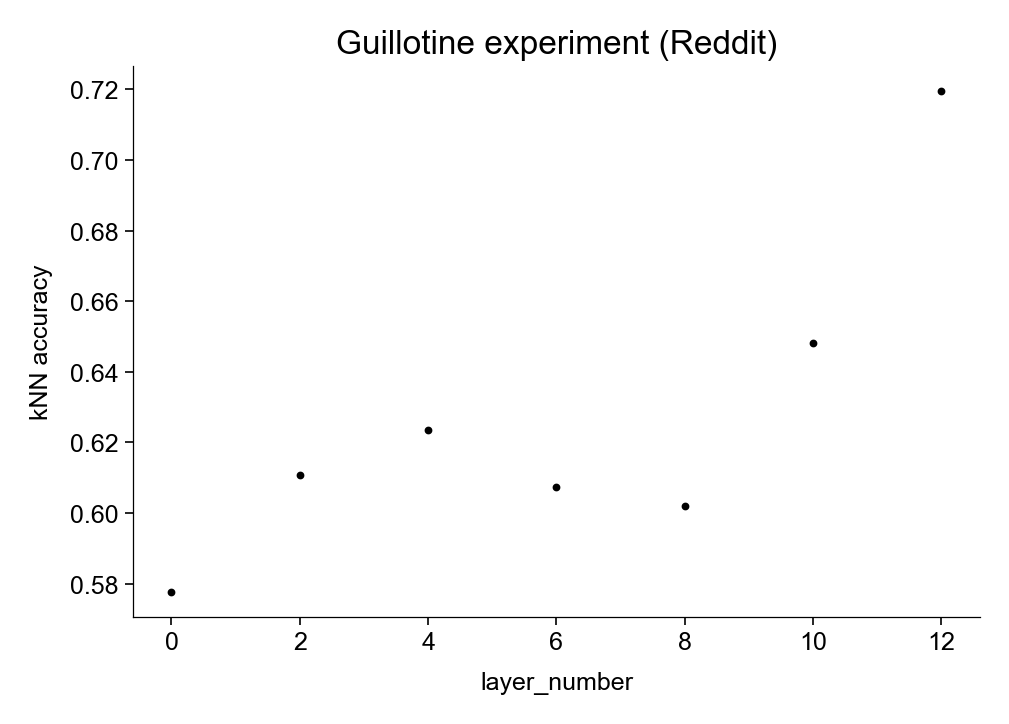

In [23]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "MPNet"
for layer_number in np.arange(7) * 2:
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path("mteb_datasets/reddit")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = (
        f"knn_accuracies_trained_av_after_layer_{layer_number}_v2.npy"
    )
    knn_acc = np.load(
        variables_path / saving_path / saving_name,
    )
    # print(layer_number, knn_acc)

    ax.scatter(layer_number, knn_acc[0], c="k", s=3, marker=".")
# ax.hlines(0.374, 0, 12, color="r")
# ax.hlines(0.374, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.374 + 0.001,
#     f"Before fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
# ax.hlines(0.589, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.589 + 0.001,
#     f"After fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title("Guillotine experiment (Reddit)")
# fig.savefig(figures_path / "guillotine_experiment_mpnet_v1.png")

In [ ]:
print(knn_acc)

[0.58692308 0.50846154 0.54384615]


### For untrained model good

In [17]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [18]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

model.to(device)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
CPU times: user 586 ms, sys: 925 ms, total: 1.51 s
Wall time: 11.6 s


MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [21]:
%%time
for layer_number in np.arange(7) * 2:
    print("layer number", layer_number)
    (
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = generate_embeddings_hidden_state(
        layer_number,
        sentences,
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    knn_acc = knn_accuracy(
        [
            embedding_av,
            embedding_cls,
            embedding_sep,
        ],
        list(np.hstack(dataset.data["test"].to_pandas().labels.to_numpy())),
    )

    # save
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path("mteb_datasets/reddit")
    )
    (variables_path / saving_path).mkdir(exist_ok=True, parents=True)

    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}_v2"
    np.save(
        variables_path / saving_path / saving_name,
        knn_acc,
    )
    print(knn_acc)
    print("-----------------------")

    # save

layer number 0


  0%|          | 0/1795 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.57710057 0.02973444 0.11462778]
-----------------------
layer number 2


	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[0.60013061 0.44730083 0.36752286]
-----------------------
layer number 10


  0%|          | 0/1795 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.62855899 0.50822812 0.47966913]
-----------------------
layer number 12


  0%|          | 0/1795 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.62642577 0.64355681 0.55100131]
-----------------------
CPU times: user 10h 45min 34s, sys: 7h 13min 29s, total: 17h 59min 3s
Wall time: 7h 51min 19s


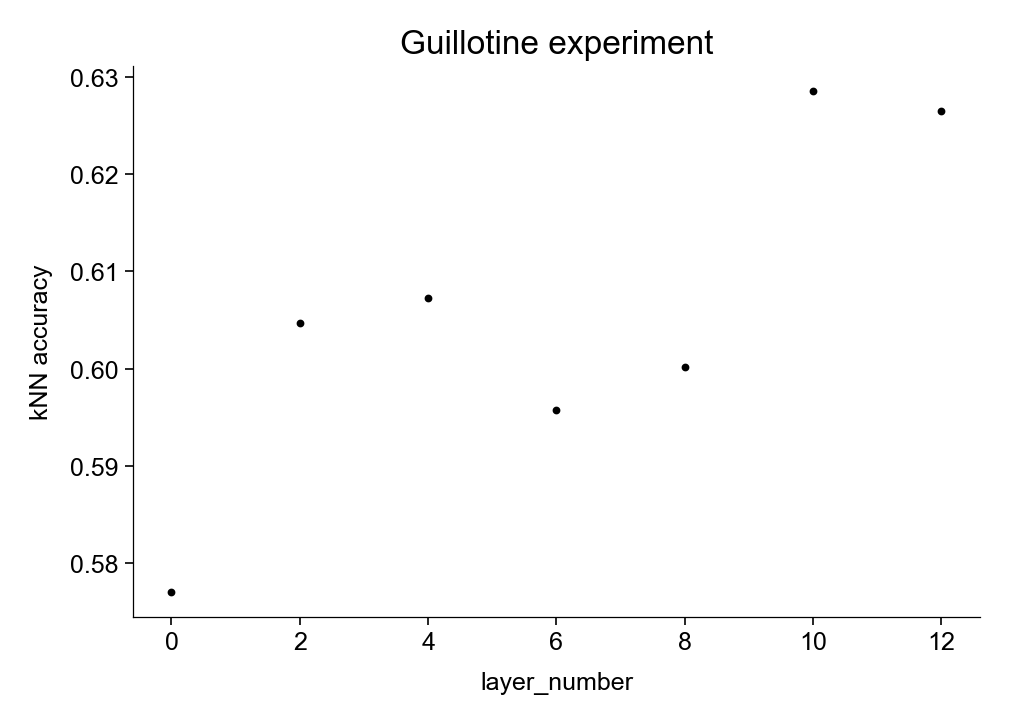

In [22]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "MPNet"
for layer_number in np.arange(7) * 2:
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path("mteb_datasets/reddit")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = (
        f"knn_accuracies_untrained_av_after_layer_{layer_number}_v2.npy"
    )
    knn_acc = np.load(
        variables_path / saving_path / saving_name,
    )
    # print(layer_number, knn_acc)

    ax.scatter(layer_number, knn_acc[0], c="k", s=3, marker=".")
# ax.hlines(0.374, 0, 12, color="r")
# ax.hlines(0.374, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.374 + 0.001,
#     f"Before fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
# ax.hlines(0.589, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.589 + 0.001,
#     f"After fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title("Guillotine experiment")
fig.savefig(figures_path / "guillotine_experiment_mpnet_v1.png")

In [ ]:
print(knn_acc)

[0.58692308 0.50846154 0.54384615]


### Plot

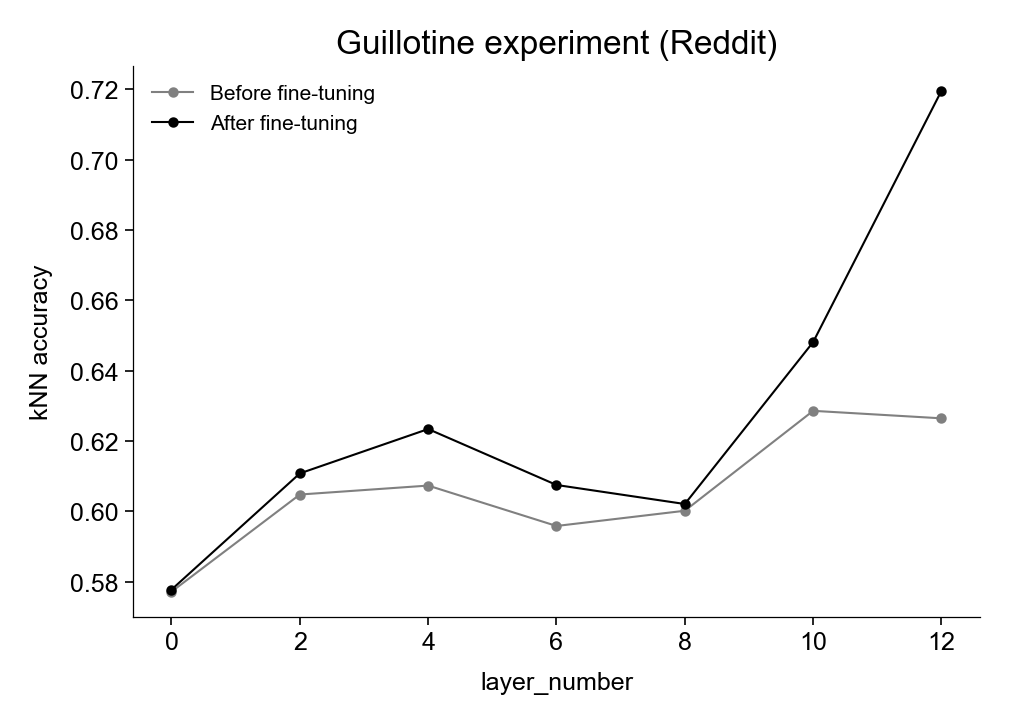

In [23]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "MPNet"
knn_acc_after_all = []
knn_acc_before_all = []
# knn_acc_after_simcse_all = []
for layer_number in np.arange(7) * 2:
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path("mteb_datasets/reddit")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = (
        f"knn_accuracies_trained_av_after_layer_{layer_number}_v2.npy"
    )
    knn_acc_after = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = (
        f"knn_accuracies_untrained_av_after_layer_{layer_number}_v2.npy"
    )
    knn_acc_before = np.load(
        variables_path / saving_path / saving_name,
    )

    # saving_name = (
    #     f"knn_accuracies_trained_simcse_av_after_layer_{layer_number}.npy"
    # )
    # knn_acc_after_simcse = np.load(
    #     variables_path / saving_path / saving_name,
    # )

    knn_acc_after_all.append(knn_acc_after[0])
    knn_acc_before_all.append(knn_acc_before[0])
    # knn_acc_after_simcse_all.append(knn_acc_after_simcse[0])

ax.plot(
    np.arange(7) * 2,
    knn_acc_before_all,
    c="grey",
    ms=3,
    marker=".",
    label="Before fine-tuning",
)

ax.plot(
    np.arange(7) * 2,
    knn_acc_after_all,
    c="k",
    ms=3,
    marker=".",
    label="After fine-tuning",
)

# ax.plot(
#     np.arange(13),
#     knn_acc_after_simcse_all,
#     c="darkred",
#     ms=3,
#     marker=".",
#     label="After SimCSE-like fine-tuning",
# )
ax.legend()
ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title("Guillotine experiment (Reddit)")
fig.savefig(figures_path / "guillotine_experiment_mpnet_reddit_v2.png")

# Guillotine Medrxiv

## Import medrxiv

In [13]:
dataset_name = "medrxiv"
dataset_path = "mteb/medrxiv-clustering-p2p"

In [14]:
dataset = load_dataset(dataset_path)

In [15]:
dataset

DatasetDict({
    test: Dataset({
        features: ['sentences', 'labels'],
        num_rows: 17647
    })
})

In [18]:
sentences = list(
    np.hstack(dataset.data["test"].to_pandas().sentences.to_numpy())
)
labels_medrxiv = list(
    np.hstack(dataset.data["test"].to_pandas().labels.to_numpy())
)

In [19]:
len(sentences)

17647

## MPNet

### For trained model

In [20]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [21]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("Training loader length: ", len(training_loader))

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Training loader length:  265
CPU times: user 1min 3s, sys: 51 s, total: 1min 54s
Wall time: 23 s


In [22]:
from tqdm.notebook import tqdm
from transformers.optimization import get_linear_schedule_with_warmup
from text_embeddings_src.model_stuff import mean_pool

##  train_loop_batches_eval modified, I eliminated the eval part.
# Apart form that it is the same as train_lood without eval
loader = training_loader
titles_abstracts_together = sentences
# tokenizer =
label_mask = np.ones(len(sentences), dtype=bool)
labels_acc = labels_medrxiv
optimized_rep = "av"
n_epochs = 1
lr = 2e-5
eval_metric = "knn"
return_seventh = False

model.to(device)

# define layers to be used in multiple-negatives-ranking
cos_sim = torch.nn.CosineSimilarity()
loss_func = torch.nn.CrossEntropyLoss()
scale = 20.0  # we multiply similarity score by this scale value
# move layers to device
cos_sim.to(device)
loss_func.to(device)

# initialize Adam optimizer
optim = torch.optim.Adam(model.parameters(), lr=lr)

# setup warmup for first ~10% of steps
total_steps = len(loader) * n_epochs
warmup_steps = int(0.1 * len(loader))
scheduler = get_linear_schedule_with_warmup(
    optim,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)

losses = np.empty((n_epochs, len(loader)))

for epoch in range(n_epochs):
    model.train()  # make sure model is in training mode
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    loop = tqdm(loader, leave=True)
    for i_batch, batch in enumerate(loop):
        # zero all gradients on each new step
        optim.zero_grad()
        # prepare batches and more all to the active device
        anchor_ids = batch[0][0].to(device)
        anchor_mask = batch[0][1].to(device)
        pos_ids = batch[1][0].to(device)
        pos_mask = batch[1][1].to(device)
        # extract token embeddings from BERT
        a = model(anchor_ids, attention_mask=anchor_mask)[
            0
        ]  # all token embeddings
        p = model(pos_ids, attention_mask=pos_mask)[0]

        # get the mean pooled vectors
        if optimized_rep == "av":
            a = mean_pool(a, anchor_mask)
            p = mean_pool(p, pos_mask)

        elif optimized_rep == "cls":
            a = cls_pool(a, anchor_mask)
            p = cls_pool(p, pos_mask)

        elif optimized_rep == "sep":
            a = sep_pool(a, anchor_mask)
            p = sep_pool(p, pos_mask)

        elif optimized_rep == "7th":
            a = seventh_pool(a, anchor_mask)
            p = seventh_pool(p, pos_mask)

        # calculate the cosine similarities
        scores = torch.stack(
            [cos_sim(a_i.reshape(1, a_i.shape[0]), p) for a_i in a]
        )
        # get label(s) - we could define this before if confident
        # of consistent batch sizes
        labels = torch.tensor(
            range(len(scores)), dtype=torch.long, device=scores.device
        )
        # and now calculate the loss
        loss = loss_func(
            scores * scale, labels
        )  # Nik does not know what the labels nor the scale are
        losses[epoch, i_batch] = loss.item()

        # using loss, calculate gradients and then optimize
        loss.backward()
        optim.step()
        # update learning rate scheduler
        scheduler.step()
        # update the TDQM progress bar
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

  0%|          | 0/265 [00:00<?, ?it/s]

In [23]:
%%time
for layer_number in np.arange(13):
    print("layer number", layer_number)
    (
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = generate_embeddings_hidden_state(
        layer_number,
        sentences,
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    knn_acc = knn_accuracy(
        [
            embedding_av,
            embedding_cls,
            embedding_sep,
        ],
        labels_medrxiv,
    )

    # save
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path(f"mteb_datasets/{dataset_name}")
    )
    (variables_path / saving_path).mkdir(exist_ok=True, parents=True)

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}"
    np.save(
        variables_path / saving_path / saving_name,
        knn_acc,
    )
    print(knn_acc)
    print("-----------------------")

    # save

layer number 0


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.42379603 0.21869688 0.18923513]
-----------------------
layer number 1


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.4305949  0.34674221 0.27252125]
-----------------------
layer number 2


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.43852691 0.33597734 0.27025496]
-----------------------
layer number 3


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.43229462 0.37223796 0.26685552]
-----------------------
layer number 4


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.43909348 0.3694051  0.2572238 ]
-----------------------
layer number 5


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.42492918 0.29575071 0.24532578]
-----------------------
layer number 6


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.41076487 0.28725212 0.31558074]
-----------------------
layer number 7


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.41586402 0.26798867 0.32067989]
-----------------------
layer number 8


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.43116147 0.27535411 0.298017  ]
-----------------------
layer number 9


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.42832861 0.28328612 0.31048159]
-----------------------
layer number 10


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.45439093 0.35014164 0.36657224]
-----------------------
layer number 11


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.49915014 0.40906516 0.41189802]
-----------------------
layer number 12


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.52351275 0.51784703 0.50991501]
-----------------------
CPU times: user 26min 42s, sys: 31min 29s, total: 58min 12s
Wall time: 33min 29s


Text(0.5, 1.0, 'Guillotine experiment (medrxiv)')

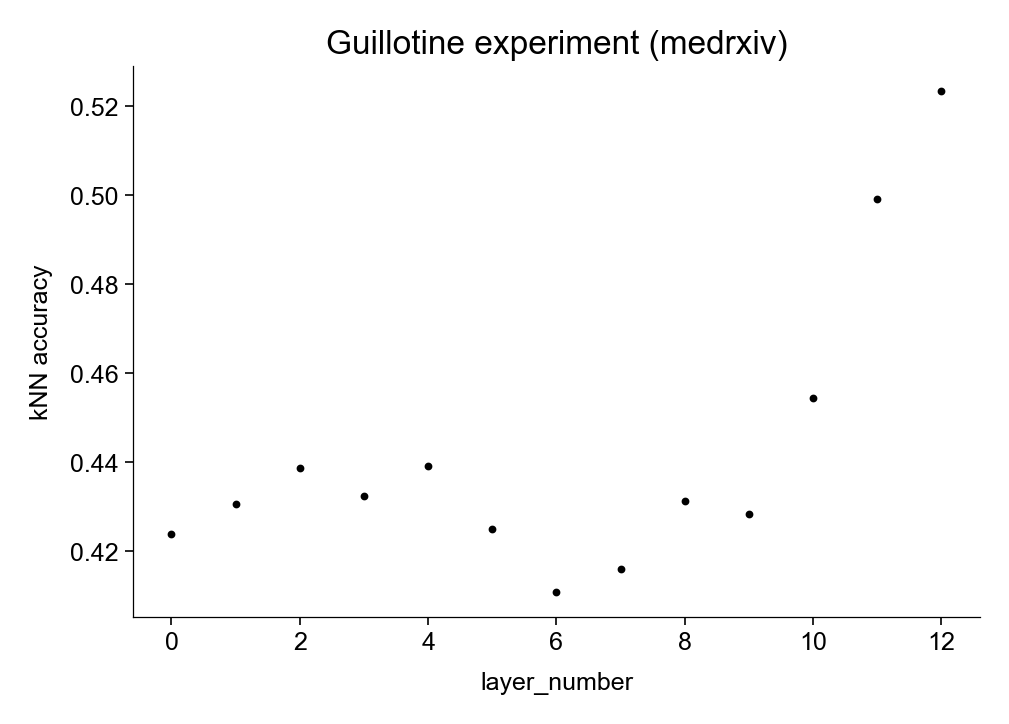

In [24]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "MPNet"
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path(f"mteb_datasets/{dataset_name}")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc = np.load(
        variables_path / saving_path / saving_name,
    )
    # print(layer_number, knn_acc)

    ax.scatter(layer_number, knn_acc[0], c="k", s=3, marker=".")
# ax.hlines(0.374, 0, 12, color="r")
# ax.hlines(0.374, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.374 + 0.001,
#     f"Before fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
# ax.hlines(0.589, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.589 + 0.001,
#     f"After fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title(f"Guillotine experiment ({dataset_name})")
# fig.savefig(figures_path / "guillotine_experiment_mpnet_v1.png")

### For untrained model good

In [25]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [26]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

model.to(device)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
CPU times: user 234 ms, sys: 196 ms, total: 430 ms
Wall time: 778 ms


MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [27]:
%%time
for layer_number in np.arange(13):
    print("layer number", layer_number)
    (
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = generate_embeddings_hidden_state(
        layer_number,
        sentences,
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    knn_acc = knn_accuracy(
        [
            embedding_av,
            embedding_cls,
            embedding_sep,
        ],
        labels_medrxiv,
    )

    # save
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path(f"mteb_datasets/{dataset_name}")
    )
    (variables_path / saving_path).mkdir(exist_ok=True, parents=True)

    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}"
    np.save(
        variables_path / saving_path / saving_name,
        knn_acc,
    )
    print(knn_acc)
    print("-----------------------")

    # save

layer number 0


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.42266289 0.21869688 0.1898017 ]
-----------------------
layer number 1


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.42719547 0.34447592 0.27818697]
-----------------------
layer number 2


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.41189802 0.33994334 0.2776204 ]
-----------------------
layer number 3


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.41869688 0.37563739 0.28611898]
-----------------------
layer number 4


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.41416431 0.36203966 0.26458924]
-----------------------
layer number 5


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.40226629 0.30764873 0.26345609]
-----------------------
layer number 6


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.39036827 0.27648725 0.30368272]
-----------------------
layer number 7


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.39150142 0.2572238  0.30878187]
-----------------------
layer number 8


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.40113314 0.24985836 0.26345609]
-----------------------
layer number 9


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.40679887 0.24419263 0.30651558]
-----------------------
layer number 10


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.42266289 0.32067989 0.34504249]
-----------------------
layer number 11


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.43909348 0.37790368 0.36997167]
-----------------------
layer number 12


  0%|          | 0/69 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.43512748 0.44192635 0.4368272 ]
-----------------------
CPU times: user 26min 38s, sys: 31min 19s, total: 57min 57s
Wall time: 33min 14s


Text(0.5, 1.0, 'Guillotine experiment')

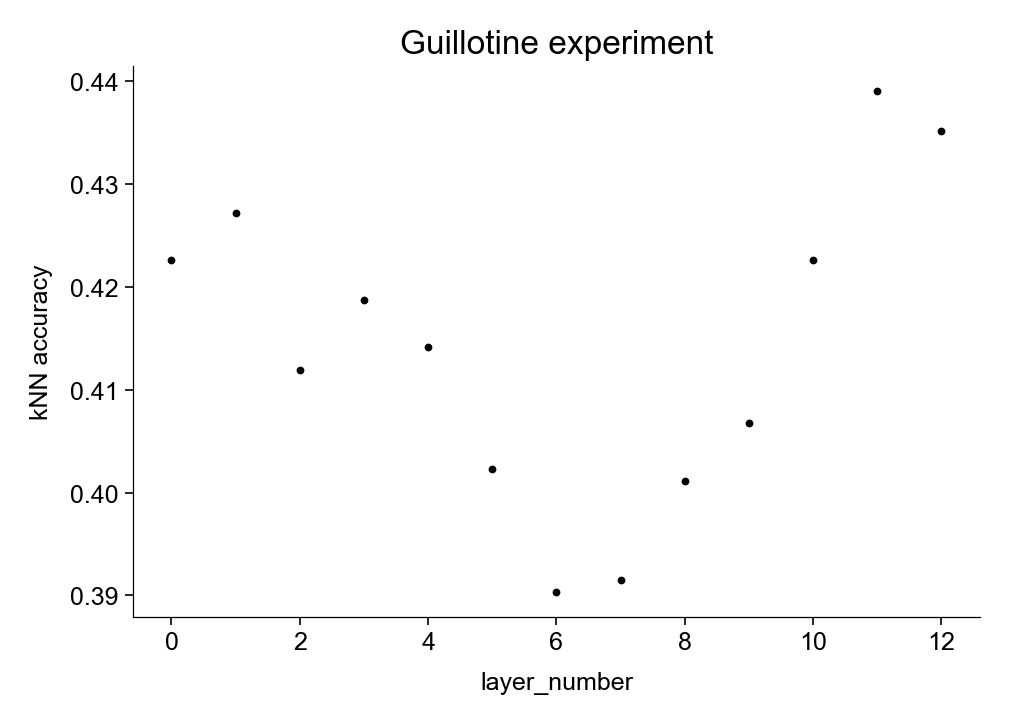

In [28]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "MPNet"
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path(f"mteb_datasets/{dataset_name}")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc = np.load(
        variables_path / saving_path / saving_name,
    )
    # print(layer_number, knn_acc)

    ax.scatter(layer_number, knn_acc[0], c="k", s=3, marker=".")
# ax.hlines(0.374, 0, 12, color="r")
# ax.hlines(0.374, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.374 + 0.001,
#     f"Before fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
# ax.hlines(0.589, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.589 + 0.001,
#     f"After fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title("Guillotine experiment")
# fig.savefig(figures_path / "guillotine_experiment_mpnet_v1.png")

### Plot

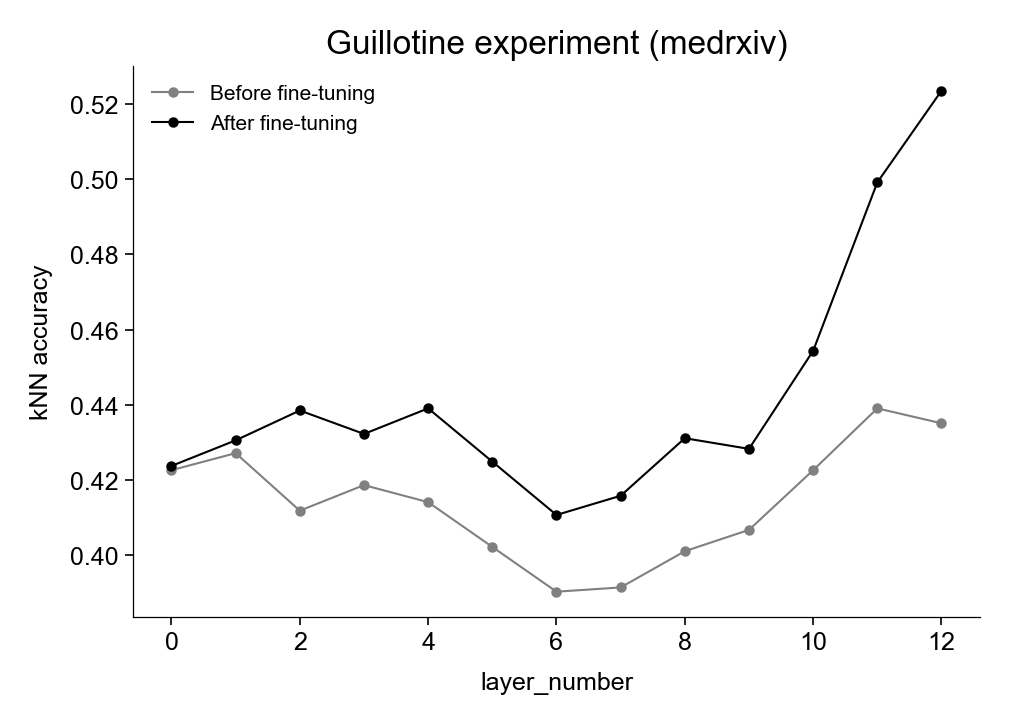

In [29]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "MPNet"
knn_acc_after_all = []
knn_acc_before_all = []
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path(f"mteb_datasets/{dataset_name}")
    )

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc_after = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before = np.load(
        variables_path / saving_path / saving_name,
    )

    # saving_name = (
    #     f"knn_accuracies_trained_simcse_av_after_layer_{layer_number}.npy"
    # )
    # knn_acc_after_simcse = np.load(
    #     variables_path / saving_path / saving_name,
    # )

    knn_acc_after_all.append(knn_acc_after[0])
    knn_acc_before_all.append(knn_acc_before[0])
    # knn_acc_after_simcse_all.append(knn_acc_after_simcse[0])

ax.plot(
    np.arange(13),
    knn_acc_before_all,
    c="grey",
    ms=3,
    marker=".",
    label="Before fine-tuning",
)

ax.plot(
    np.arange(13),
    knn_acc_after_all,
    c="k",
    ms=3,
    marker=".",
    label="After fine-tuning",
)

# ax.plot(
#     np.arange(13),
#     knn_acc_after_simcse_all,
#     c="darkred",
#     ms=3,
#     marker=".",
#     label="After SimCSE-like fine-tuning",
# )
ax.legend()
ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title(f"Guillotine experiment ({dataset_name})")
fig.savefig(figures_path / f"guillotine_experiment_mpnet_{dataset_name}.png")

# Guillotine stackexchange

## Import stackexchange

In [12]:
dataset_name = "stackexchange"
dataset_path = "mteb/stackexchange-clustering-p2p"

In [13]:
dataset = load_dataset(dataset_path)

In [14]:
dataset

DatasetDict({
    test: Dataset({
        features: ['sentences', 'labels'],
        num_rows: 10
    })
})

In [15]:
sentences = list(
    np.hstack(dataset.data["test"].to_pandas().sentences.to_numpy())
)
labels_stackexchange = list(
    np.hstack(dataset.data["test"].to_pandas().labels.to_numpy())
)

In [16]:
len(sentences)

75000

## MPNet

### For trained model

In [17]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [18]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    pd.Series(sentences),
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("Training loader length: ", len(training_loader))

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Training loader length:  650
CPU times: user 2min 22s, sys: 1min 6s, total: 3min 29s
Wall time: 34.4 s


In [19]:
from tqdm.notebook import tqdm
from transformers.optimization import get_linear_schedule_with_warmup
from text_embeddings_src.model_stuff import mean_pool

##  train_loop_batches_eval modified, I eliminated the eval part.
# Apart form that it is the same as train_lood without eval
loader = training_loader
titles_abstracts_together = sentences
# tokenizer =
label_mask = np.ones(len(sentences), dtype=bool)
labels_acc = labels_stackexchange
optimized_rep = "av"
n_epochs = 1
lr = 2e-5
eval_metric = "knn"
return_seventh = False

model.to(device)

# define layers to be used in multiple-negatives-ranking
cos_sim = torch.nn.CosineSimilarity()
loss_func = torch.nn.CrossEntropyLoss()
scale = 20.0  # we multiply similarity score by this scale value
# move layers to device
cos_sim.to(device)
loss_func.to(device)

# initialize Adam optimizer
optim = torch.optim.Adam(model.parameters(), lr=lr)

# setup warmup for first ~10% of steps
total_steps = len(loader) * n_epochs
warmup_steps = int(0.1 * len(loader))
scheduler = get_linear_schedule_with_warmup(
    optim,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)

losses = np.empty((n_epochs, len(loader)))

for epoch in range(n_epochs):
    model.train()  # make sure model is in training mode
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    loop = tqdm(loader, leave=True)
    for i_batch, batch in enumerate(loop):
        # zero all gradients on each new step
        optim.zero_grad()
        # prepare batches and more all to the active device
        anchor_ids = batch[0][0].to(device)
        anchor_mask = batch[0][1].to(device)
        pos_ids = batch[1][0].to(device)
        pos_mask = batch[1][1].to(device)
        # extract token embeddings from BERT
        a = model(anchor_ids, attention_mask=anchor_mask)[
            0
        ]  # all token embeddings
        p = model(pos_ids, attention_mask=pos_mask)[0]

        # get the mean pooled vectors
        if optimized_rep == "av":
            a = mean_pool(a, anchor_mask)
            p = mean_pool(p, pos_mask)

        elif optimized_rep == "cls":
            a = cls_pool(a, anchor_mask)
            p = cls_pool(p, pos_mask)

        elif optimized_rep == "sep":
            a = sep_pool(a, anchor_mask)
            p = sep_pool(p, pos_mask)

        elif optimized_rep == "7th":
            a = seventh_pool(a, anchor_mask)
            p = seventh_pool(p, pos_mask)

        # calculate the cosine similarities
        scores = torch.stack(
            [cos_sim(a_i.reshape(1, a_i.shape[0]), p) for a_i in a]
        )
        # get label(s) - we could define this before if confident
        # of consistent batch sizes
        labels = torch.tensor(
            range(len(scores)), dtype=torch.long, device=scores.device
        )
        # and now calculate the loss
        loss = loss_func(
            scores * scale, labels
        )  # Nik does not know what the labels nor the scale are
        losses[epoch, i_batch] = loss.item()

        # using loss, calculate gradients and then optimize
        loss.backward()
        optim.step()
        # update learning rate scheduler
        scheduler.step()
        # update the TDQM progress bar
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

  0%|          | 0/650 [00:00<?, ?it/s]

In [20]:
%%time
for layer_number in np.arange(13):
    print("layer number", layer_number)
    (
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = generate_embeddings_hidden_state(
        layer_number,
        sentences,
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    knn_acc = knn_accuracy(
        [
            embedding_av,
            embedding_cls,
            embedding_sep,
        ],
        labels_stackexchange,
    )

    # save
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path(f"mteb_datasets/{dataset_name}")
    )
    (variables_path / saving_path).mkdir(exist_ok=True, parents=True)

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}"
    np.save(
        variables_path / saving_path / saving_name,
        knn_acc,
    )
    print(knn_acc)
    print("-----------------------")

    # save

layer number 0


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.42453333 0.052      0.15173333]
-----------------------
layer number 1


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.41026667 0.35973333 0.28146667]
-----------------------
layer number 2


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.39573333 0.33346667 0.27666667]
-----------------------
layer number 3


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.39706667 0.32026667 0.27706667]
-----------------------
layer number 4


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.39706667 0.32213333 0.2728    ]
-----------------------
layer number 5


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.39346667 0.29786667 0.26186667]
-----------------------
layer number 6


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.38106667 0.29546667 0.2864    ]
-----------------------
layer number 7


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.37533333 0.29293333 0.28293333]
-----------------------
layer number 8


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.38213333 0.29533333 0.27866667]
-----------------------
layer number 9


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.39693333 0.29413333 0.27533333]
-----------------------
layer number 10


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.40373333 0.31426667 0.30333333]
-----------------------
layer number 11


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.42986667 0.41013333 0.34933333]
-----------------------
layer number 12


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.45613333 0.4596     0.4144    ]
-----------------------
CPU times: user 1h 54min 34s, sys: 2h 10min 58s, total: 4h 5min 32s
Wall time: 2h 21min 33s


Text(0.5, 1.0, 'Guillotine experiment (stackexchange)')

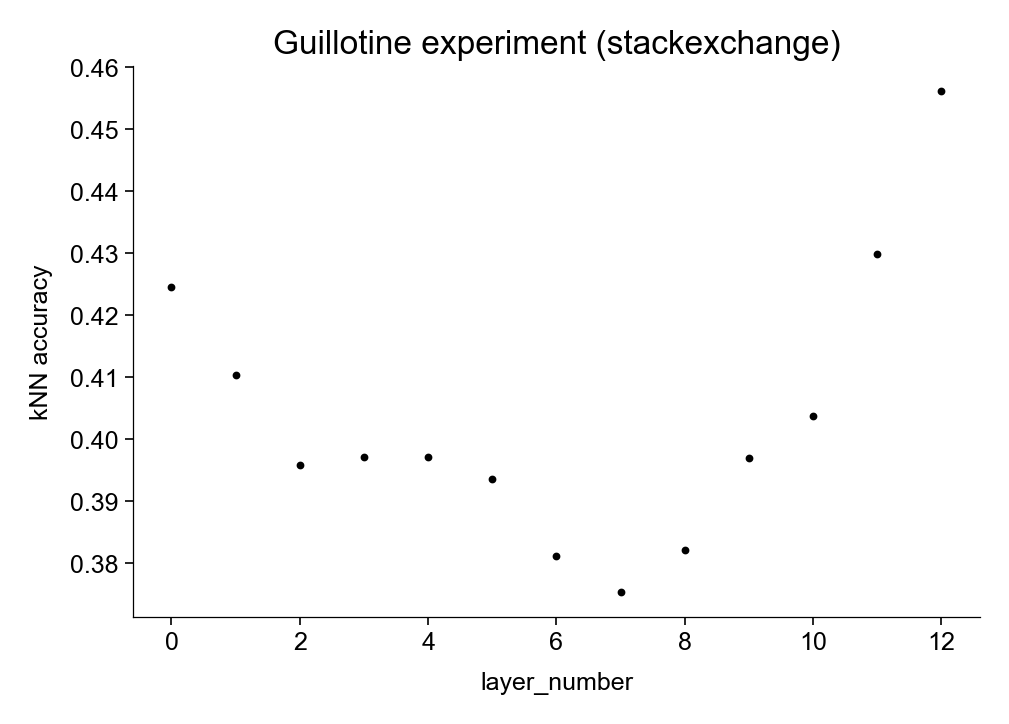

In [21]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "MPNet"
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path(f"mteb_datasets/{dataset_name}")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc = np.load(
        variables_path / saving_path / saving_name,
    )
    # print(layer_number, knn_acc)

    ax.scatter(layer_number, knn_acc[0], c="k", s=3, marker=".")
# ax.hlines(0.374, 0, 12, color="r")
# ax.hlines(0.374, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.374 + 0.001,
#     f"Before fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
# ax.hlines(0.589, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.589 + 0.001,
#     f"After fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title(f"Guillotine experiment ({dataset_name})")
# fig.savefig(figures_path / "guillotine_experiment_mpnet_v1.png")

### For untrained model good

In [22]:
model_names = [
    "MPNet",
]


model_paths = [
    "microsoft/mpnet-base",
]

In [23]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
i = 0
model_name = model_names[i]

print("Model: ", model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

model.to(device)

Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
CPU times: user 224 ms, sys: 551 ms, total: 775 ms
Wall time: 4.36 s


MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [24]:
%%time
for layer_number in np.arange(13):
    print("layer number", layer_number)
    (
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = generate_embeddings_hidden_state(
        layer_number,
        sentences,
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    knn_acc = knn_accuracy(
        [
            embedding_av,
            embedding_cls,
            embedding_sep,
        ],
        labels_stackexchange,
    )

    # save
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path(f"mteb_datasets/{dataset_name}")
    )
    (variables_path / saving_path).mkdir(exist_ok=True, parents=True)

    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}"
    np.save(
        variables_path / saving_path / saving_name,
        knn_acc,
    )
    print(knn_acc)
    print("-----------------------")

    # save

layer number 0


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.42466667 0.052      0.1564    ]
-----------------------
layer number 1


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.40906667 0.35386667 0.2836    ]
-----------------------
layer number 2


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.39213333 0.32786667 0.27373333]
-----------------------
layer number 3


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.39106667 0.32413333 0.28293333]
-----------------------
layer number 4


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.38653333 0.3236     0.2748    ]
-----------------------
layer number 5


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.3784     0.30253333 0.2596    ]
-----------------------
layer number 6


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.36626667 0.29146667 0.2828    ]
-----------------------
layer number 7


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.35466667 0.28026667 0.2788    ]
-----------------------
layer number 8


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.36306667 0.27493333 0.27013333]
-----------------------
layer number 9


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.36493333 0.28146667 0.28      ]
-----------------------
layer number 10


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.3792     0.30066667 0.28533333]
-----------------------
layer number 11


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.38973333 0.36973333 0.32373333]
-----------------------
layer number 12


  0%|          | 0/293 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.39293333 0.39946667 0.3504    ]
-----------------------
CPU times: user 1h 51min 36s, sys: 2h 9min 59s, total: 4h 1min 36s
Wall time: 2h 20min 17s


Text(0.5, 1.0, 'Guillotine experiment')

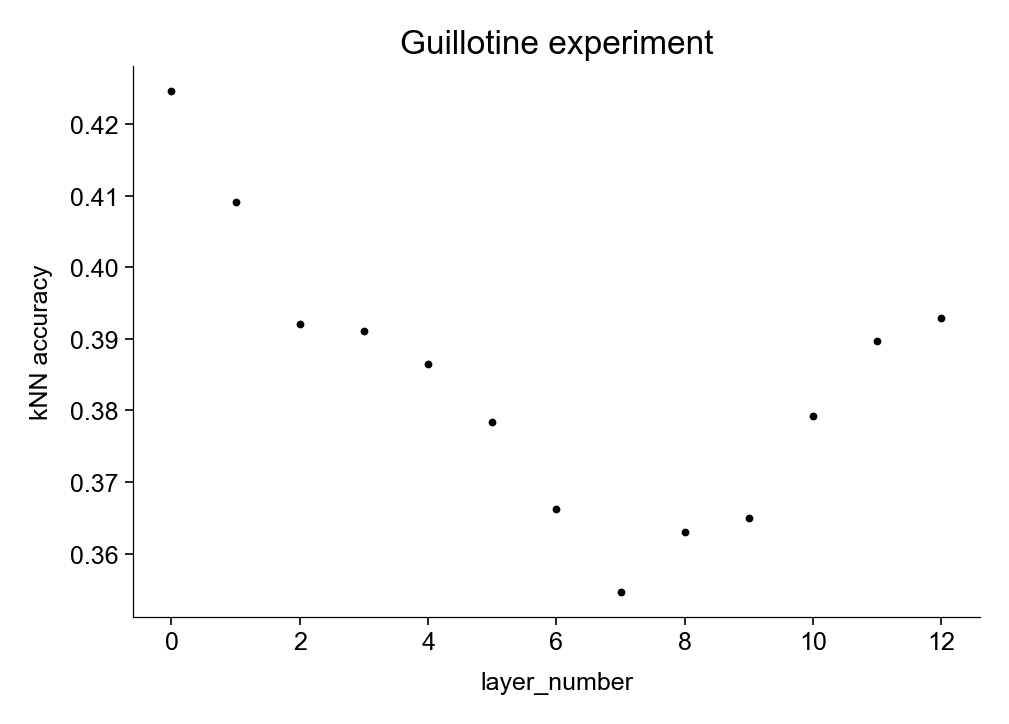

In [25]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "MPNet"
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path(f"mteb_datasets/{dataset_name}")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc = np.load(
        variables_path / saving_path / saving_name,
    )
    # print(layer_number, knn_acc)

    ax.scatter(layer_number, knn_acc[0], c="k", s=3, marker=".")
# ax.hlines(0.374, 0, 12, color="r")
# ax.hlines(0.374, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.374 + 0.001,
#     f"Before fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
# ax.hlines(0.589, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.589 + 0.001,
#     f"After fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title("Guillotine experiment")
# fig.savefig(figures_path / "guillotine_experiment_mpnet_v1.png")

### Plot

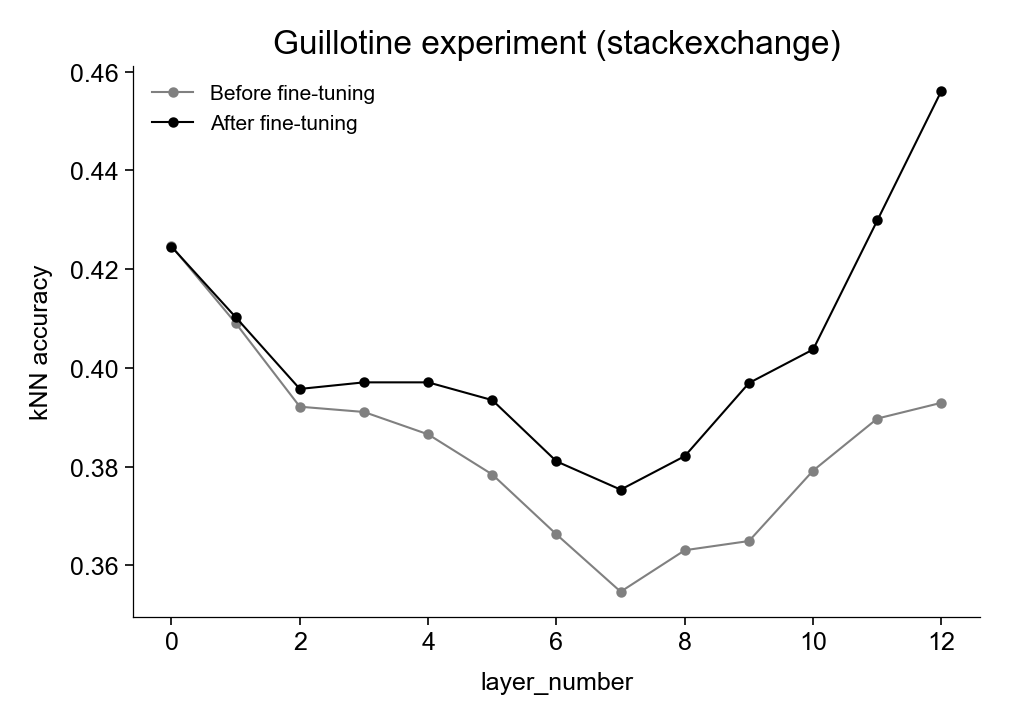

In [26]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "MPNet"
knn_acc_after_all = []
knn_acc_before_all = []
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
        / Path(f"mteb_datasets/{dataset_name}")
    )

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc_after = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before = np.load(
        variables_path / saving_path / saving_name,
    )

    # saving_name = (
    #     f"knn_accuracies_trained_simcse_av_after_layer_{layer_number}.npy"
    # )
    # knn_acc_after_simcse = np.load(
    #     variables_path / saving_path / saving_name,
    # )

    knn_acc_after_all.append(knn_acc_after[0])
    knn_acc_before_all.append(knn_acc_before[0])
    # knn_acc_after_simcse_all.append(knn_acc_after_simcse[0])

ax.plot(
    np.arange(13),
    knn_acc_before_all,
    c="grey",
    ms=3,
    marker=".",
    label="Before fine-tuning",
)

ax.plot(
    np.arange(13),
    knn_acc_after_all,
    c="k",
    ms=3,
    marker=".",
    label="After fine-tuning",
)

# ax.plot(
#     np.arange(13),
#     knn_acc_after_simcse_all,
#     c="darkred",
#     ms=3,
#     marker=".",
#     label="After SimCSE-like fine-tuning",
# )
ax.legend()
ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title(f"Guillotine experiment ({dataset_name})")
fig.savefig(figures_path / f"guillotine_experiment_mpnet_{dataset_name}.png")